In [1]:
    # HIERARCHICAL REINFORCEMENT LEARNING FOR SPARSE-REWARD NAVIGATION
# PointMaze with DQN, HER, and HAC

# # Hierarchical Reinforcement Learning for Sparse-Reward Navigation
# ## PointMaze with DQN, HER, and HAC
#
# **Project Structure:**
# - **Tier 1**: DQN backbone with discrete actions and clean training/evaluation pipeline
# - **Tier 2**: Goal-conditioning + HER with ablation studies
# - **Tier 3**: HAC-style Hierarchical RL for long-horizon navigation

In [2]:
# ============================================================================
# INSTALLATION CELL
# ============================================================================

# Install required packages
!pip install gymnasium[mujoco] gymnasium-robotics stable-baselines3 sb3-contrib tensorboard matplotlib pandas seaborn tqdm moviepy imageio --quiet

# For rendering in Colab - install EGL support
!apt-get update -qq
!apt-get install -y -qq xvfb ffmpeg libegl1-mesa-dev libgl1-mesa-dev libgles2-mesa-dev > /dev/null 2>&1
!pip install pyvirtualdisplay --quiet

# Set environment variables for MuJoCo EGL rendering
import os
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'

print("✓ Installation complete!")
print("✓ MuJoCo EGL rendering configured")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 23.1 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✓ Installation complete!
✓ MuJoCo EGL rendering configured


In [3]:
# ============================================================================
# IMPORTS AND CONFIGURATION
# ============================================================================

# === CRITICAL: Set MuJoCo rendering backend BEFORE any imports ===
import os
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import gymnasium as gym
import gymnasium_robotics
from gymnasium.wrappers import RecordEpisodeStatistics
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
import json
import time
from datetime import datetime
from collections import deque, defaultdict
from typing import Dict, List, Tuple, Optional, Any, Union, Callable
from dataclasses import dataclass, field, asdict
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Stable Baselines 3
from stable_baselines3 import DQN, SAC
from stable_baselines3.common.buffers import ReplayBuffer, DictReplayBuffer
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

# SB3-Contrib for TQC
from sb3_contrib import TQC

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import HTML, display, clear_output
import base64
from pathlib import Path

# Video recording
try:
    from gymnasium.wrappers import RecordVideo
    VIDEO_RECORDING_AVAILABLE = True
except ImportError:
    VIDEO_RECORDING_AVAILABLE = False
    print("Warning: RecordVideo wrapper not available")

# Virtual display for headless rendering (Colab)
try:
    from pyvirtualdisplay import Display
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()
    print("✓ Virtual display started for rendering")
except Exception as e:
    print(f"Virtual display not available: {e}")

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {DEVICE}")

# Gymnasium robotics registration
gym.register_envs(gymnasium_robotics)
print("✓ Gymnasium-Robotics environments registered")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✓ Virtual display started for rendering
✓ Using device: cuda
✓ Gymnasium-Robotics environments registered


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
# ============================================================================
# MAZE CONFIGURATIONS
# ============================================================================

# Define maze configurations for experiments
MAZE_CONFIGS = {
    'small': {
        'env_id': 'PointMaze_UMaze-v3',
        'name': 'Small (UMaze)',
        'max_episode_steps': 500,
        'subgoal_range_x': (-0.5, 5.5),  # Add margin for noise
        'subgoal_range_y': (-0.5, 5.5),
        'subgoal_period_k': 15,
    },
    'large': {
        'env_id': 'PointMaze_Large-v3',
        'name': 'Large',
        'max_episode_steps': 5000,
        'subgoal_range_x': (-0.5, 12.5),  # 12 columns
        'subgoal_range_y': (-0.5, 9.5),   # 9 rows
        'subgoal_period_k': 30,
    }
}

print("✓ Maze configurations defined")
print(f"  Small: {MAZE_CONFIGS['small']['env_id']}, K={MAZE_CONFIGS['small']['subgoal_period_k']}")
print(f"  Large: {MAZE_CONFIGS['large']['env_id']}, K={MAZE_CONFIGS['large']['subgoal_period_k']}")

env = gym.make('PointMaze_Large-v3')
for _ in range(100):
    obs, _ = env.reset()
    print(f"Goal: {obs['desired_goal']}, Agent: {obs['achieved_goal']}")

✓ Maze configurations defined
  Small: PointMaze_UMaze-v3, K=15
  Large: PointMaze_Large-v3, K=30
Goal: [2.33235434 0.90079455], Agent: [0.33491088 1.02443576]
Goal: [1.32771148 3.07100563], Agent: [ 0.74593622 -3.11150459]
Goal: [-1.31761661  2.80999161], Agent: [ 1.41356419 -1.16489117]
Goal: [0.44704035 2.88176992], Agent: [-3.29883139  3.17000401]
Goal: [4.50516022 0.12934829], Agent: [-1.64085571 -1.09171799]
Goal: [-4.48911304  0.00890148], Agent: [ 2.25727015 -1.90128726]
Goal: [-3.4643726  0.9851386], Agent: [ 4.56943864 -2.89455   ]
Goal: [ 1.4218799 -1.115695 ], Agent: [ 3.36633415 -2.89748941]
Goal: [2.5369409  2.87960204], Agent: [-4.67407859  2.21555173]
Goal: [-1.39359338 -2.80353727], Agent: [-3.42747837 -2.09633716]
Goal: [ 4.54497803 -3.12069875], Agent: [0.45873684 3.15200253]
Goal: [ 4.57059242 -2.9660971 ], Agent: [-4.32230121 -0.81520218]
Goal: [-3.25694876 -3.24830515], Agent: [2.54665199 2.11280629]
Goal: [-1.37425661 -2.95555979], Agent: [ 0.62569825 -2.87387563

In [5]:
# ============================================================================
# EXPERIMENT CONFIGURATION
# ============================================================================

# =============================================================================
# [FAST MODE] Set to True for progress report (faster training, 1 seed)
# [FULL MODE] Set to False for final report (full training, 3+ seeds)
# =============================================================================
FAST_MODE = True

@dataclass
class ExperimentConfig:
    """Central configuration for all experiments."""

    # === Environment Settings (will be overridden per maze) ===
    maze_map: str = "PointMaze_Large-v3"
    maze_size: str = "large"  # 'small' or 'large'
    max_episode_steps: int = 1000
    continuing_task: bool = False

    # === Discrete Action Settings (for DQN only) ===
    n_discrete_actions: int = 4  # up, down, left, right
    action_magnitude: float = 1.0

    # === Continuous Action Settings (for HAC) ===
    action_dim: int = 2  # Continuous action dimension for PointMaze
    action_scale: float = 1.0  # Max action magnitude

    # === Training Settings ===
    total_timesteps: int = 50_000 if FAST_MODE else 500_000
    learning_rate: float = 1e-3
    buffer_size: int = 50_000 if FAST_MODE else 500_000
    batch_size: int = 256
    learning_starts: int = 5000
    tau: float = 0.005
    gamma: float = 0.99
    train_freq: int = 4
    gradient_steps: int = 1

    # === DQN-Specific Settings ===
    exploration_fraction: float = 0.5
    exploration_initial_eps: float = 1.0
    exploration_final_eps: float = 0.1
    target_update_interval: int = 1000

    # === HER Settings ===
    her_strategy: str = "future"
    her_n_sampled_goal: int = 4

    # === HAC (Hierarchical) Settings ===
    subgoal_period_k: int = 15
    subgoal_dim: int = 2
    subgoal_range_x: Tuple[float, float] = (-0.5, 8.5)
    subgoal_range_y: Tuple[float, float] = (-0.5, 8.5)
    high_level_lr: float = 3e-4
    low_level_lr: float = 3e-4

    # === HAC Reward Scaling ===
    high_reward_scale: float = 1.0  # Scale for high-level rewards
    low_reward_scale: float = 1.0   # Scale for low-level rewards
    subgoal_test_penalty_scale: float = 1.0  # Penalty = -1.0 * scale (not -K!)

    # === TD3 Settings for continuous low-level ===
    policy_noise: float = 0.2
    noise_clip: float = 0.5
    policy_delay: int = 2
    exploration_noise: float = 0.1

    max_grad_norm: float = 1.0

    # === Evaluation Settings ===
    eval_freq: int = 5_000
    n_eval_episodes: int = 20 if FAST_MODE else 50
    deterministic_eval: bool = True

    # === Reward Settings ===
    use_dense_reward: bool = True
    success_threshold: float = 0.5
    subgoal_threshold: float = 0.5

    # === Reproducibility ===
    seeds: List[int] = field(default_factory=lambda: [42] if FAST_MODE else [42, 123, 456])

    # === Network Architecture ===
    policy_kwargs: Dict = field(default_factory=lambda: {
        "net_arch": [256, 256]
    })

    # === Logging ===
    log_dir: str = "./logs"
    save_models: bool = True

    def update_for_maze(self, maze_size: str):
        """Update config for specific maze size."""
        maze_cfg = MAZE_CONFIGS[maze_size]
        self.maze_size = maze_size
        self.maze_map = maze_cfg['env_id']
        self.max_episode_steps = maze_cfg['max_episode_steps']
        self.subgoal_range_x = maze_cfg['subgoal_range_x']
        self.subgoal_range_y = maze_cfg['subgoal_range_y']
        self.subgoal_period_k = maze_cfg['subgoal_period_k']
        return self

    def to_dict(self) -> Dict:
        d = asdict(self)
        d['seeds'] = list(d['seeds'])
        return d


# Create default config
config = ExperimentConfig()
print(f"\n✓ Configuration loaded (FAST_MODE={FAST_MODE})")
print(f"  Total timesteps: {config.total_timesteps:,}")
print(f"  Seeds: {config.seeds}")
print(f"  Action scale: {config.action_scale} (PointMaze expects [-1, 1])")
print(f"  Max grad norm: {config.max_grad_norm}")

test_env = gym.make('PointMaze_UMaze-v3')
env_threshold = getattr(test_env.unwrapped, 'goal_distance_threshold', 'unknown')
print(f"  Environment's goal_distance_threshold: {env_threshold}")
print(f"  Config success_threshold: {config.success_threshold}")
if env_threshold != 'unknown' and abs(env_threshold - config.success_threshold) > 0.01:
    print("  ⚠️ WARNING: Threshold mismatch!")
test_env.close()


✓ Configuration loaded (FAST_MODE=True)
  Total timesteps: 50,000
  Seeds: [42]
  Action scale: 1.0 (PointMaze expects [-1, 1])
  Max grad norm: 1.0
  Environment's goal_distance_threshold: unknown
  Config success_threshold: 0.5


In [6]:
# ============================================================================
# DISCRETE ACTION WRAPPER (FOR DQN ONLY)
# ============================================================================

class DiscreteActionWrapper(gym.ActionWrapper):
    """
    Converts continuous action space to discrete.
    ONLY used for DQN-based methods, NOT for HAC.

    Actions:
    0: Up (+y)
    1: Down (-y)
    2: Left (-x)
    3: Right (+x)
    """

    def __init__(self, env: gym.Env, n_actions: int = 4, magnitude: float = 1.0, repeat: int = 5):
        super().__init__(env)
        self.n_actions = n_actions
        self.magnitude = min(magnitude, 1.0)
        self.repeat = repeat

        # Define action mappings
        self.action_map = {
            0: np.array([0.0, self.magnitude]),    # up (+y)
            1: np.array([0.0, -self.magnitude]),   # down (-y)
            2: np.array([-self.magnitude, 0.0]),   # left (-x)
            3: np.array([self.magnitude, 0.0]),    # right (+x)
        }


        self.action_space = gym.spaces.Discrete(n_actions)

    def step(self, action):
        """Repeat the action multiple times to simulate meaningful movement."""
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}
        success_achieved = False  # Track success across all repeats
        steps_taken = 0

        cont_action = self.action(action)

        for _ in range(self.repeat):
            obs, reward, term, trunc, info = self.env.step(cont_action)
            total_reward += reward
            steps_taken += 1
            terminated = terminated or term
            truncated = truncated or trunc
            if info.get('is_success', False):  # Track success
                success_achieved = True
            if terminated or truncated:
                break

        info['is_success'] = success_achieved  # Preserve success flag
        info['actual_steps'] = steps_taken

        return obs, total_reward / (i + 1), terminated, truncated, info

    def action(self, action) -> np.ndarray:
        """Convert discrete action to continuous."""
        if isinstance(action, np.ndarray):
            action = int(action.item())
        elif not isinstance(action, int):
            action = int(action)

        if action not in self.action_map:  # Add this check
            raise ValueError(f"Invalid action {action}, must be in {list(self.action_map.keys())}")

        return self.action_map[action]


print("✓ DiscreteActionWrapper defined (for DQN methods only)")
print("Action mapping:")
for idx, act in DiscreteActionWrapper(gym.make('PointMaze_UMaze-v3'), magnitude=1.0).action_map.items():
    print(f"  {idx}: {act}")

✓ DiscreteActionWrapper defined (for DQN methods only)
Action mapping:
  0: [0. 1.]
  1: [ 0. -1.]
  2: [-1.  0.]
  3: [1. 0.]


In [7]:
# ============================================================================
# ENVIRONMENT UTILITIES
# ============================================================================

class DenseRewardWrapper(gym.Wrapper):
    """Adds dense reward shaping to help learning."""

    def __init__(self, env: gym.Env, success_bonus: float = 1.0, replace_reward=True):
        super().__init__(env)
        self.success_bonus = success_bonus
        self._prev_distance = None
        self.replace_reward = replace_reward

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        achieved = obs['achieved_goal']
        desired = obs['desired_goal']
        self._prev_distance = np.linalg.norm(achieved - desired)
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        achieved = obs['achieved_goal']
        desired = obs['desired_goal']
        current_distance = np.linalg.norm(achieved - desired)

        dense_reward = self._prev_distance - current_distance
        self._prev_distance = current_distance

        if info.get('is_success', False):
            dense_reward += self.success_bonus

        # Compute final reward
        if self.replace_reward:
            final_reward = dense_reward
        else:
            final_reward = reward + dense_reward

        info['original_reward'] = reward
        info['dense_reward'] = dense_reward

        return obs, dense_reward, terminated, truncated, info


def make_env(
    config,
    seed: int = 42,
    use_discrete: bool = True,
    use_dense_reward: bool = None,
    render_mode: Optional[str] = None
) -> gym.Env:
    """
    Create environment with all wrappers applied.

    Args:
        config: Experiment configuration
        seed: Random seed
        use_discrete: If True, wrap with DiscreteActionWrapper (for DQN)
                      If False, keep continuous actions (for HAC)
        use_dense_reward: Whether to use dense reward shaping
        render_mode: Rendering mode for visualization
    """
    if use_dense_reward is None:
        use_dense_reward = config.use_dense_reward

    env = gym.make(
        config.maze_map,
        max_episode_steps=config.max_episode_steps,
        continuing_task=config.continuing_task,
        render_mode=render_mode
    )

    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    if use_dense_reward:
        env = DenseRewardWrapper(env)

    # Only apply discrete wrapper for DQN methods
    if use_discrete:
        env = DiscreteActionWrapper(
            env,
            n_actions=config.n_discrete_actions,
            magnitude=1.0,
            repeat=1
        )

    env = RecordEpisodeStatistics(env)
    env = Monitor(env)
    env.reset(seed=seed)
    return env


def get_env_info(env: gym.Env) -> Dict:
    """Get environment information for logging."""
    obs, _ = env.reset()
    return {
        "observation_shape": obs['observation'].shape,
        "achieved_goal_shape": obs['achieved_goal'].shape,
        "desired_goal_shape": obs['desired_goal'].shape,
        "action_space": env.action_space,
    }


# Test environment creation for both maze sizes
print("\n" + "=" * 60)
print("Testing Environment Creation")
print("=" * 60)

for maze_size in ['small', 'large']:
    test_config = ExperimentConfig().update_for_maze(maze_size)

    # Test discrete env (for DQN)
    test_env_discrete = make_env(test_config, seed=42, use_discrete=True)
    info_discrete = get_env_info(test_env_discrete)
    print(f"\n{MAZE_CONFIGS[maze_size]['name']} Maze (Discrete - for DQN):")
    print(f"  Env: {test_config.maze_map}")
    print(f"  Action space: {info_discrete['action_space']}")
    test_env_discrete.close()

    # Test continuous env (for HAC)
    test_env_cont = make_env(test_config, seed=42, use_discrete=False)
    info_cont = get_env_info(test_env_cont)
    print(f"\n{MAZE_CONFIGS[maze_size]['name']} Maze (Continuous - for HAC):")
    print(f"  Env: {test_config.maze_map}")
    print(f"  Action space: {info_cont['action_space']}")
    test_env_cont.close()


Testing Environment Creation

Small (UMaze) Maze (Discrete - for DQN):
  Env: PointMaze_UMaze-v3
  Action space: Discrete(4)

Small (UMaze) Maze (Continuous - for HAC):
  Env: PointMaze_UMaze-v3
  Action space: Box(-1.0, 1.0, (2,), float32)

Large Maze (Discrete - for DQN):
  Env: PointMaze_Large-v3
  Action space: Discrete(4)

Large Maze (Continuous - for HAC):
  Env: PointMaze_Large-v3
  Action space: Box(-1.0, 1.0, (2,), float32)


In [8]:
# DEBUG: Environment sanity check
print("=" * 50)
print("ENVIRONMENT SANITY CHECK")
print("=" * 50)

test_config = ExperimentConfig().update_for_maze('small')
env = gym.make(test_config.maze_map, max_episode_steps=test_config.max_episode_steps)

obs, _ = env.reset()
print(f"Action space: {env.action_space}")
print(f"Action range: [{env.action_space.low}, {env.action_space.high}]")
print(f"\n--- Observations ---")
print(f"Observation keys: {list(obs.keys())}")
print(f"obs['observation'] shape: {obs['observation'].shape} → [x, y, vx, vy]")
print(f"obs['achieved_goal'] shape: {obs['achieved_goal'].shape}")
print(f"obs['desired_goal'] shape: {obs['desired_goal'].shape}")
print(f"\n--- Initial State ---")
print(f"Agent position: {obs['achieved_goal']}")
print(f"Goal position: {obs['desired_goal']}")
print(f"Initial distance: {np.linalg.norm(obs['achieved_goal'] - obs['desired_goal']):.3f}")
print(f"\n--- Thresholds ---")
env_threshold = getattr(env.unwrapped, 'goal_distance_threshold', 'unknown')
print(f"Env goal_distance_threshold: {env_threshold}")
print(f"Config success_threshold: {test_config.success_threshold}")

# Quick random rollout
print(f"\n--- Random Policy Test (100 steps) ---")
min_dist = float('inf')
for i in range(100):
    action = env.action_space.sample()
    obs, reward, term, trunc, info = env.step(action)
    dist = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])
    min_dist = min(min_dist, dist)
    if info.get('is_success'):
        print(f"SUCCESS at step {i}!")
        break
else:
    print(f"No success (expected for random policy)")
    print(f"Minimum distance achieved: {min_dist:.3f}")

env.close()
print("\n✓ Environment sanity check complete")

ENVIRONMENT SANITY CHECK
Action space: Box(-1.0, 1.0, (2,), float32)
Action range: [[-1. -1.], [1. 1.]]

--- Observations ---
Observation keys: ['observation', 'achieved_goal', 'desired_goal']
obs['observation'] shape: (4,) → [x, y, vx, vy]
obs['achieved_goal'] shape: (2,)
obs['desired_goal'] shape: (2,)

--- Initial State ---
Agent position: [-0.080002    1.02541212]
Goal position: [ 0.04636181 -1.04905454]
Initial distance: 2.078

--- Thresholds ---
Env goal_distance_threshold: unknown
Config success_threshold: 0.5

--- Random Policy Test (100 steps) ---
No success (expected for random policy)
Minimum distance achieved: 2.055

✓ Environment sanity check complete


In [9]:
# DEBUG: DiscreteActionWrapper behavior
print("\n" + "=" * 50)
print("DISCRETE ACTION WRAPPER CHECK")
print("=" * 50)

test_config = ExperimentConfig().update_for_maze('small')
test_env = make_env(test_config, seed=42, use_discrete=True, use_dense_reward=True)
obs, _ = test_env.reset()

print(f"Wrapped action space: {test_env.action_space} (n={test_env.action_space.n})")

# Test each action direction once
action_names = {0: 'UP (+y)', 1: 'DOWN (-y)', 2: 'LEFT (-x)', 3: 'RIGHT (+x)'}
print("\n--- Single-step action test ---")
for action_idx in range(min(4, test_env.action_space.n)):
    obs, _ = test_env.reset()
    start = obs['achieved_goal'].copy()
    obs, reward, _, _, _ = test_env.step(action_idx)
    delta = obs['achieved_goal'] - start
    print(f"Action {action_idx} ({action_names[action_idx]:10s}): Δx={delta[0]:+.3f}, Δy={delta[1]:+.3f}, r={reward:.3f}")

# Test repeated UP action
print("\n--- Repeated UP action (10 steps) ---")
obs, _ = test_env.reset()
print(f"Start: {obs['achieved_goal']}")
for i in range(10):
    obs, reward, term, trunc, info = test_env.step(0)
    if term or trunc:
        print(f"Step {i+1}: Episode ended (success={info.get('is_success')})")
        break
print(f"End:   {obs['achieved_goal']}")
print(f"Total Y movement: {obs['achieved_goal'][1] - obs['achieved_goal'][1]:.3f}")

test_env.close()
print("\n✓ Discrete wrapper check complete")


DISCRETE ACTION WRAPPER CHECK
Wrapped action space: Discrete(4) (n=4)

--- Single-step action test ---
Action 0 (UP (+y)   ): Δx=+0.000, Δy=+0.002, r=-0.000
Action 1 (DOWN (-y) ): Δx=+0.000, Δy=-0.002, r=0.000
Action 2 (LEFT (-x) ): Δx=-0.002, Δy=+0.000, r=0.000
Action 3 (RIGHT (+x)): Δx=+0.002, Δy=+0.000, r=0.000

--- Repeated UP action (10 steps) ---
Start: [-0.06477015 -1.01522209]
End:   [-0.06477015 -0.88516345]
Total Y movement: 0.000

✓ Discrete wrapper check complete


In [10]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

@dataclass
class EpisodeMetrics:
    """Metrics for a single evaluation episode."""
    success: bool
    steps: int
    total_reward: float
    path_length: float
    goal_distance: float
    final_distance: float

    @property
    def path_efficiency(self) -> float:
        if self.path_length > 0:
            return self.goal_distance / self.path_length
        return 0.0
    @property
    def normalized_steps(self) -> float:
        """Steps normalized by initial goal distance."""
        if self.goal_distance > 0:
            return self.steps / self.goal_distance
        return float('inf')


@dataclass
class AggregatedMetrics:
    """Aggregated metrics over multiple episodes."""
    success_rate: float
    success_rate_std: float
    mean_steps: float
    std_steps: float
    mean_steps_successful: float
    mean_reward: float
    std_reward: float
    mean_path_efficiency: float
    std_path_efficiency: float
    n_episodes: int

    def to_dict(self) -> Dict:
        return asdict(self)

    def __str__(self) -> str:
        return (
            f"Success: {self.success_rate:.1%}±{self.success_rate_std:.1%} | "
            f"Steps: {self.mean_steps:.1f}±{self.std_steps:.1f} | "
            f"Efficiency: {self.mean_path_efficiency:.2f}±{self.std_path_efficiency:.2f}"
        )


def aggregate_metrics(episodes: List[EpisodeMetrics]) -> AggregatedMetrics:
    """Aggregate episode metrics with proper handling of edge cases."""
    n = len(episodes)
    successes = [ep.success for ep in episodes]
    steps = [ep.steps for ep in episodes]
    rewards = [ep.total_reward for ep in episodes]
    efficiencies = [ep.path_efficiency for ep in episodes]

    successful_steps = [ep.steps for ep in episodes if ep.success]

    return AggregatedMetrics(
        success_rate=np.mean(successes),
        success_rate_std=np.std(successes) / np.sqrt(n),
        mean_steps=np.mean(steps),
        std_steps=np.std(steps),
        mean_steps_successful=np.mean(successful_steps) if successful_steps else float('nan'),
        mean_reward=np.mean(rewards),
        std_reward=np.std(rewards),
        mean_path_efficiency=np.mean(efficiencies),
        std_path_efficiency=np.std(efficiencies),
        n_episodes=n
    )


def set_seeds(seed: int):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


print("✓ Utility functions defined")

✓ Utility functions defined


In [11]:
# ============================================================================
# LIVE TRAINING VISUALIZATION
# ============================================================================

class LiveLossPlotter:
    """Real-time loss plotting during training."""

    def __init__(
        self,
        update_freq: int = 100,
        window_size: int = 1000,
        figsize: Tuple[int, int] = (14, 5)
    ):
        self.update_freq = update_freq
        self.window_size = window_size
        self.figsize = figsize

        self.losses = defaultdict(list)
        self.steps = []
        self.step_count = 0

        self.eval_steps = []
        self.eval_success_rates = []
        self.eval_rewards = []

        self.fig = None
        self.axes = None

    def setup(self):
        self.fig, self.axes = plt.subplots(1, 3, figsize=self.figsize)

        self.axes[0].set_title('Training Losses')
        self.axes[0].set_xlabel('Steps')
        self.axes[0].set_ylabel('Loss')
        self.axes[0].grid(True, alpha=0.3)

        self.axes[1].set_title('Success Rate')
        self.axes[1].set_xlabel('Steps')
        self.axes[1].set_ylabel('Success Rate (%)')
        self.axes[1].set_ylim(0, 100)
        self.axes[1].grid(True, alpha=0.3)

        self.axes[2].set_title('Mean Reward')
        self.axes[2].set_xlabel('Steps')
        self.axes[2].set_ylabel('Reward')
        self.axes[2].grid(True, alpha=0.3)

        plt.tight_layout()

    def add_loss(self, step: int, losses_dict: Dict[str, float]):
        self.step_count = step
        self.steps.append(step)

        for name, value in losses_dict.items():
            self.losses[name].append(value)

    def add_eval_metrics(self, step: int, success_rate: float, mean_reward: float):
        self.eval_steps.append(step)
        self.eval_success_rates.append(success_rate * 100)
        self.eval_rewards.append(mean_reward)

    def update_plot(self, force: bool = False):
        if not force and self.step_count % self.update_freq != 0:
            return

        if self.fig is None:
            self.setup()

        clear_output(wait=True)

        self.axes[0].clear()
        self.axes[0].set_title('Training Losses')
        self.axes[0].set_xlabel('Steps')
        self.axes[0].set_ylabel('Loss')
        self.axes[0].grid(True, alpha=0.3)

        start_idx = max(0, len(self.steps) - self.window_size)
        display_steps = self.steps[start_idx:]

        for name, values in self.losses.items():
            display_values = values[start_idx:]
            if len(display_values) > 0:
                self.axes[0].plot(display_steps, display_values, label=name, alpha=0.8)

        if self.losses:
            self.axes[0].legend(loc='upper right', fontsize=8)

        self.axes[1].clear()
        self.axes[1].set_title('Success Rate')
        self.axes[1].set_xlabel('Steps')
        self.axes[1].set_ylabel('Success Rate (%)')
        self.axes[1].set_ylim(0, 100)
        self.axes[1].grid(True, alpha=0.3)
        if self.eval_success_rates:
            self.axes[1].plot(self.eval_steps, self.eval_success_rates, 'b-o', markersize=4)

        self.axes[2].clear()
        self.axes[2].set_title('Mean Reward')
        self.axes[2].set_xlabel('Steps')
        self.axes[2].set_ylabel('Reward')
        self.axes[2].grid(True, alpha=0.3)
        if self.eval_rewards:
            self.axes[2].plot(self.eval_steps, self.eval_rewards, 'g-o', markersize=4)

        plt.tight_layout()
        display(self.fig)

    def close(self):
        if self.fig is not None:
            plt.close(self.fig)

    def save_figure(self, path: str):
        """Save current figure to file."""
        if self.fig is not None:
            self.fig.savefig(path, dpi=150, bbox_inches='tight')

    def get_summary(self) -> Dict:
        """Get summary statistics for logging."""
        return {
            'final_success_rate': self.eval_success_rates[-1] if self.eval_success_rates else 0,
            'best_success_rate': max(self.eval_success_rates) if self.eval_success_rates else 0,
            'final_reward': self.eval_rewards[-1] if self.eval_rewards else 0,
            'total_steps': self.step_count,}


print("✓ LiveLossPlotter defined")

✓ LiveLossPlotter defined


In [12]:
# ============================================================================
# EVALUATION CALLBACK FOR DQN
# ============================================================================

class LiveRenderCallback(BaseCallback):
    """Callback for live rendering and evaluation during training."""

    def __init__(
        self,
        eval_env: gym.Env,
        eval_freq: int = 5000,
        n_eval_episodes: int = 10,
        plot_freq: int = 500,
        success_threshold: float = 0.5,
        verbose: int = 1
    ):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.plot_freq = plot_freq
        self.success_threshold = success_threshold

        self.loss_plotter = LiveLossPlotter(update_freq=plot_freq)
        self.eval_history = []
        self.best_success_rate = 0.0

    def _on_step(self) -> bool:

        if self.n_calls % 10000 == 0:
          eps_str = f", epsilon={self.model.exploration_rate:.3f}" if hasattr(self.model, 'exploration_rate') else ""
          print(f"Step {self.n_calls}{eps_str}")

        if self.n_calls % self.plot_freq == 0:
            if hasattr(self.model, 'logger') and self.model.logger is not None:
                try:
                    loss = self.model.logger.name_to_value.get('train/loss', 0)
                    self.loss_plotter.add_loss(self.n_calls, {'dqn_loss': loss})
                except (AttributeError, KeyError):
                    pass

        if self.n_calls % self.eval_freq == 0:
            metrics = self._evaluate()
            self.eval_history.append(metrics)

            if metrics['success_rate'] > self.best_success_rate:
                self.best_success_rate = metrics['success_rate']

            self.loss_plotter.add_eval_metrics(
                self.n_calls,
                metrics['success_rate'],
                metrics.get('mean_reward', 0)
            )
            self.loss_plotter.update_plot(force=True)

        return True

    def _evaluate(self) -> Dict:
        successes = []
        steps_list = []
        rewards_list = []
        path_lengths = []
        goal_distances = []

        # threshold once per eval
        threshold = getattr(self.eval_env.unwrapped, "goal_distance_threshold", None)
        if threshold is None:
            threshold = getattr(self, "success_threshold", 0.5)  # fallback

        for ep_idx in range(self.n_eval_episodes):
            obs, _ = self.eval_env.reset()

            if not (isinstance(obs, dict) and ("achieved_goal" in obs) and ("desired_goal" in obs)):
                raise ValueError("Eval env must return dict obs with achieved_goal & desired_goal for this evaluator.")



            start_pos = obs['achieved_goal'].copy()
            goal_pos = obs['desired_goal'].copy()
            goal_distance = np.linalg.norm(goal_pos - start_pos)

            done = False
            steps = 0
            total_reward = 0
            success = False
            path_length = 0.0
            prev_pos = start_pos.copy()


            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self.eval_env.step(action)
                done = terminated or truncated
                steps += 1
                total_reward += reward

                current_pos = obs['achieved_goal']
                path_length += np.linalg.norm(current_pos - prev_pos)
                prev_pos = current_pos.copy()

                 # distance-based success + info-based success
                dist = np.linalg.norm(obs["achieved_goal"] - obs["desired_goal"])
                if info.get("is_success", False) or info.get("success", False) or dist < threshold:
                    success = True



            if ep_idx < 3:  # Print first 3 episodes only
                final_dist = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])

                print(f"  Eval ep: steps={steps}, final_dist={final_dist:.3f}, is_success={info.get('is_success')}, success_var={success}")

            successes.append(float(success))
            steps_list.append(steps)
            rewards_list.append(total_reward)
            path_lengths.append(path_length)
            goal_distances.append(goal_distance)

        efficiencies = [gd / pl if pl > 0 else 0 for gd, pl in zip(goal_distances, path_lengths)]

        return {
            'timestep': self.n_calls,
            'success_rate': np.mean(successes),
            'success_rate_std': np.std(successes),
            'mean_steps': np.mean(steps_list),
            'std_steps': np.std(steps_list),
            'mean_reward': np.mean(rewards_list),
            'mean_path_efficiency': np.mean(efficiencies),
        }

    def get_eval_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.eval_history)

    def _on_training_end(self):
        self.loss_plotter.close()


print("✓ LiveRenderCallback defined")

✓ LiveRenderCallback defined


In [13]:
# ============================================================================
# TIER 1: DQN WITH DENSE REWARD
# ============================================================================

def train_dqn_live(
    config: ExperimentConfig,
    seed: int,
    experiment_name: str = "tier1_live",
    use_dense_reward: bool = None,
    plot_freq: int = 500
) -> Tuple[Any, pd.DataFrame]:
    """Train DQN with live loss plots."""
    set_seeds(seed)

    if use_dense_reward is None:
        use_dense_reward = config.use_dense_reward

    log_dir = os.path.join(config.log_dir, f"{experiment_name}_{config.maze_size}_dqn_seed{seed}")
    os.makedirs(log_dir, exist_ok=True)

    # DQN uses discrete actions
    train_env = make_env(config, seed=seed, use_discrete=True, use_dense_reward=use_dense_reward)
    eval_env = make_env(config, seed=seed + 1000, use_discrete=True, use_dense_reward=False)

    print(f"\n{'=' * 60}")
    print(f"🎯 Training DQN (Dense Reward) - {MAZE_CONFIGS[config.maze_size]['name']} Maze")
    print(f"Seed: {seed}, Total Steps: {config.total_timesteps:,}")
    print(f"{'=' * 60}\n")

    model = DQN(
        "MultiInputPolicy",
        train_env,
        learning_rate=config.learning_rate,
        buffer_size=config.buffer_size,
        batch_size=config.batch_size,
        learning_starts=config.learning_starts,
        tau=config.tau,
        gamma=config.gamma,
        train_freq=config.train_freq,
        gradient_steps=config.gradient_steps,
        exploration_fraction=config.exploration_fraction,
        exploration_initial_eps=config.exploration_initial_eps,
        exploration_final_eps=config.exploration_final_eps,
        target_update_interval=config.target_update_interval,
        policy_kwargs=config.policy_kwargs,
        tensorboard_log=log_dir,
        verbose=0,
        seed=seed,
        device=DEVICE,
    )

    live_callback = LiveRenderCallback(
        eval_env=eval_env,
        eval_freq=config.eval_freq,
        n_eval_episodes=config.n_eval_episodes,
        plot_freq=plot_freq,
        success_threshold=config.success_threshold,
        verbose=1
    )

    model.learn(
        total_timesteps=config.total_timesteps,
        callback=live_callback,
        progress_bar=True
    )

    if config.save_models:
        model_path = os.path.join(log_dir, "final_model")
        model.save(model_path)
        print(f"Model saved to {model_path}")

    eval_df = live_callback.get_eval_df()
    eval_df['seed'] = seed
    eval_df['algorithm'] = 'dqn_dense'
    eval_df['maze_size'] = config.maze_size

    train_env.close()
    eval_env.close()



    return model, eval_df


print("✓ train_dqn_live() defined")

✓ train_dqn_live() defined


In [14]:
# ============================================================================
# TIER 2: DQN + HER (WITH ABLATION)
# ============================================================================

def train_dqn_her_live(
    config: ExperimentConfig,
    seed: int,
    use_her: bool = True,
    experiment_name: str = "tier2_live",
    plot_freq: int = 500
) -> Tuple[Any, pd.DataFrame]:
    """
    Train DQN with or without HER.
    """
    set_seeds(seed)

    her_str = "with_her" if use_her else "no_her"
    log_dir = os.path.join(config.log_dir, f"{experiment_name}_{config.maze_size}_dqn_{her_str}_seed{seed}")
    os.makedirs(log_dir, exist_ok=True)

    # DQN uses discrete actions, sparse rewards for HER ablation
    train_env = make_env(config, seed=seed, use_discrete=True, use_dense_reward=False)
    eval_env = make_env(config, seed=seed + 1000, use_discrete=True, use_dense_reward=False)

    print(f"\n{'=' * 60}")
    print(f"🎯 Training DQN {'WITH' if use_her else 'WITHOUT'} HER - {MAZE_CONFIGS[config.maze_size]['name']} Maze")
    print(f"Seed: {seed}, Total Steps: {config.total_timesteps:,}")
    print(f"{'=' * 60}\n")

    if use_her:
        replay_buffer_class = HerReplayBuffer
        replay_buffer_kwargs = {
            "n_sampled_goal": config.her_n_sampled_goal,
            "goal_selection_strategy": config.her_strategy,
        }
        print(f"HER config: strategy={config.her_strategy}, n_sampled_goal={config.her_n_sampled_goal}")
    else:
        replay_buffer_class = DictReplayBuffer
        replay_buffer_kwargs = {}
        print("Using standard DictReplayBuffer (no HER)")

    model = DQN(
        "MultiInputPolicy",
        train_env,
        learning_rate=config.learning_rate,
        buffer_size=config.buffer_size,
        batch_size=config.batch_size,
        learning_starts=config.learning_starts,
        tau=config.tau,
        gamma=config.gamma,
        train_freq=config.train_freq,
        gradient_steps=config.gradient_steps,
        exploration_fraction=config.exploration_fraction,
        exploration_initial_eps=config.exploration_initial_eps,
        exploration_final_eps=config.exploration_final_eps,
        target_update_interval=config.target_update_interval,
        replay_buffer_class=replay_buffer_class,
        replay_buffer_kwargs=replay_buffer_kwargs,
        policy_kwargs=config.policy_kwargs,
        tensorboard_log=log_dir,
        verbose=0,
        seed=seed,
        device=DEVICE,
    )

    live_callback = LiveRenderCallback(
        eval_env=eval_env,
        eval_freq=config.eval_freq,
        n_eval_episodes=config.n_eval_episodes,
        plot_freq=plot_freq,
        success_threshold=config.success_threshold,
        verbose=1
    )

    model.learn(
        total_timesteps=config.total_timesteps,
        callback=live_callback,
        progress_bar=True
    )

    print(f"Replay buffer class: {type(model.replay_buffer)}")
    print(f"Buffer kwargs: {replay_buffer_kwargs}")

    if config.save_models:
        model_path = os.path.join(log_dir, "final_model")
        model.save(model_path)
        print(f"✓ Model saved to {model_path}")

    eval_df = live_callback.get_eval_df()
    eval_df['seed'] = seed
    eval_df['algorithm'] = f'dqn_{her_str}'
    eval_df['use_her'] = use_her
    eval_df['maze_size'] = config.maze_size

    train_env.close()
    eval_env.close()

    return model, eval_df


print("✓ train_dqn_her_live() defined")

✓ train_dqn_her_live() defined


In [15]:
# ============================================================================
# EVALUATION CALLBACK FOR CONTINUOUS ACTION METHODS (SAC, TQC)
# ============================================================================

class LiveRenderCallbackContinuous(BaseCallback):
    """Callback for live rendering and evaluation for continuous action methods."""

    def __init__(
        self,
        eval_env: gym.Env,
        eval_freq: int = 5000,
        n_eval_episodes: int = 10,
        plot_freq: int = 500,
        success_threshold: float = 0.5,
        verbose: int = 1
    ):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.plot_freq = plot_freq
        self.success_threshold = success_threshold

        self.loss_plotter = LiveLossPlotter(update_freq=plot_freq)
        self.eval_history = []
        self.best_success_rate = 0.0

    def _on_step(self) -> bool:
        if self.n_calls % self.plot_freq == 0:
            if hasattr(self.model, 'logger') and self.model.logger is not None:
                try:
                    losses = {}
                    for key in ['train/actor_loss', 'train/critic_loss', 'train/ent_coef_loss']:
                        val = self.model.logger.name_to_value.get(key, None)
                        if val is not None:
                            losses[key.split('/')[-1]] = val
                    if losses:
                        self.loss_plotter.add_loss(self.n_calls, losses)
                except (AttributeError, KeyError):
                    pass

        if self.n_calls % self.eval_freq == 0:
            metrics = self._evaluate()
            self.eval_history.append(metrics)

            if metrics['success_rate'] > self.best_success_rate:
                self.best_success_rate = metrics['success_rate']

            self.loss_plotter.add_eval_metrics(
                self.n_calls,
                metrics['success_rate'],
                metrics.get('mean_reward', 0)
            )
            self.loss_plotter.update_plot(force=True)

        return True

    def _evaluate(self) -> Dict:
        successes = []
        steps_list = []
        rewards_list = []
        path_lengths = []
        goal_distances = []

        threshold = getattr(self.eval_env.unwrapped, "goal_distance_threshold", None)
        if threshold is None:
            threshold = self.success_threshold

        for ep_idx in range(self.n_eval_episodes):
            obs, _ = self.eval_env.reset()
            start_pos = obs['achieved_goal'].copy()
            goal_pos = obs['desired_goal'].copy()
            goal_distance = np.linalg.norm(goal_pos - start_pos)

            done = False
            steps = 0
            total_reward = 0
            success = False
            path_length = 0.0
            prev_pos = start_pos.copy()

            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = self.eval_env.step(action)
                done = terminated or truncated
                steps += 1
                total_reward += reward

                current_pos = obs['achieved_goal']
                path_length += np.linalg.norm(current_pos - prev_pos)
                prev_pos = current_pos.copy()

                dist = np.linalg.norm(obs["achieved_goal"] - obs["desired_goal"])
                if info.get('is_success', False) or dist < threshold:
                    success = True

            if ep_idx < 3:  # Debug first 3 episodes
                final_dist = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])
                print(f"  Eval ep {ep_idx}: steps={steps}, final_dist={final_dist:.3f}, success={success}")


            successes.append(float(success))
            steps_list.append(steps)
            rewards_list.append(total_reward)
            path_lengths.append(path_length)
            goal_distances.append(goal_distance)

        efficiencies = [gd / pl if pl > 0 else 0 for gd, pl in zip(goal_distances, path_lengths)]

        return {
            'timestep': self.n_calls,
            'success_rate': np.mean(successes),
            'success_rate_std': np.std(successes),
            'mean_steps': np.mean(steps_list),
            'std_steps': np.std(steps_list),
            'mean_reward': np.mean(rewards_list),
            'mean_path_efficiency': np.mean(efficiencies),
        }

    def get_eval_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.eval_history)

    def _on_training_end(self):
        self.loss_plotter.close()


print("✓ LiveRenderCallbackContinuous defined")

✓ LiveRenderCallbackContinuous defined


In [16]:
# ============================================================================
# SAC (Soft Actor-Critic) WITH/WITHOUT HER
# ============================================================================

def train_sac_live(
    config: ExperimentConfig,
    seed: int,
    use_her: bool = True,
    experiment_name: str = "sac_live",
    plot_freq: int = 500
) -> Tuple[Any, pd.DataFrame]:
    """
    Train SAC with or without HER.
    Uses CONTINUOUS actions (native action space).
    """
    set_seeds(seed)

    her_str = "with_her" if use_her else "no_her"
    log_dir = os.path.join(config.log_dir, f"{experiment_name}_{config.maze_size}_sac_{her_str}_seed{seed}")
    os.makedirs(log_dir, exist_ok=True)

    # SAC uses CONTINUOUS actions (no discrete wrapper)
    train_env = make_env(config, seed=seed, use_discrete=False, use_dense_reward=False)
    eval_env = make_env(config, seed=seed + 1000, use_discrete=False, use_dense_reward=False)

    print(f"\n{'=' * 60}")
    print(f"🎯 Training SAC {'WITH' if use_her else 'WITHOUT'} HER - {MAZE_CONFIGS[config.maze_size]['name']} Maze")
    print(f"Seed: {seed}, Total Steps: {config.total_timesteps:,}")
    print(f"Action Space: Continuous")
    print(f"{'=' * 60}\n")

    if use_her:
        replay_buffer_class = HerReplayBuffer
        replay_buffer_kwargs = {
            "n_sampled_goal": config.her_n_sampled_goal,
            "goal_selection_strategy": config.her_strategy,
        }
        print(f"HER config: strategy={config.her_strategy}, n_sampled_goal={config.her_n_sampled_goal}")
    else:
        replay_buffer_class = DictReplayBuffer
        replay_buffer_kwargs = {}
        print("Using standard DictReplayBuffer (no HER)")

    model = SAC(
        "MultiInputPolicy",
        train_env,
        learning_rate=config.high_level_lr,
        buffer_size=config.buffer_size,
        batch_size=config.batch_size,
        learning_starts=config.learning_starts,
        tau=config.tau,
        gamma=config.gamma,
        train_freq=1,
        gradient_steps=1,
        ent_coef='auto',  # Automatic entropy tuning (default, but explicit is good)
        target_entropy='auto',  # Automatic target entropy
        replay_buffer_class=replay_buffer_class,
        replay_buffer_kwargs=replay_buffer_kwargs,
        policy_kwargs=config.policy_kwargs,
        tensorboard_log=log_dir,
        verbose=0,
        seed=seed,
        device=DEVICE,
    )

    # Create callback for continuous action evaluation
    live_callback = LiveRenderCallbackContinuous(
        eval_env=eval_env,
        eval_freq=config.eval_freq,
        n_eval_episodes=config.n_eval_episodes,
        plot_freq=plot_freq,
        success_threshold=config.success_threshold,
        verbose=1
    )

    model.learn(
        total_timesteps=config.total_timesteps,
        callback=live_callback,
        progress_bar=True
    )

    if config.save_models:
        model_path = os.path.join(log_dir, "final_model")
        model.save(model_path)
        print(f"✓ Model saved to {model_path}")

    eval_df = live_callback.get_eval_df()
    eval_df['seed'] = seed
    eval_df['algorithm'] = f'sac_{her_str}'
    eval_df['use_her'] = use_her
    eval_df['maze_size'] = config.maze_size

    train_env.close()
    eval_env.close()

    return model, eval_df


print("✓ train_sac_live() defined")

✓ train_sac_live() defined


In [17]:
# ============================================================================
# TQC (Truncated Quantile Critics) WITH/WITHOUT HER
# ============================================================================

def train_tqc_live(
    config: ExperimentConfig,
    seed: int,
    use_her: bool = True,
    experiment_name: str = "tqc_live",
    plot_freq: int = 500
) -> Tuple[Any, pd.DataFrame]:
    """
    Train TQC with or without HER.
    Uses CONTINUOUS actions (native action space).
    TQC extends SAC with distributional critics and truncation.
    """
    set_seeds(seed)

    her_str = "with_her" if use_her else "no_her"
    log_dir = os.path.join(config.log_dir, f"{experiment_name}_{config.maze_size}_tqc_{her_str}_seed{seed}")
    os.makedirs(log_dir, exist_ok=True)

    # TQC uses CONTINUOUS actions (no discrete wrapper)
    train_env = make_env(config, seed=seed, use_discrete=False, use_dense_reward=False)
    eval_env = make_env(config, seed=seed + 1000, use_discrete=False, use_dense_reward=False)

    print(f"\n{'=' * 60}")
    print(f"🎯 Training TQC {'WITH' if use_her else 'WITHOUT'} HER - {MAZE_CONFIGS[config.maze_size]['name']} Maze")
    print(f"Seed: {seed}, Total Steps: {config.total_timesteps:,}")
    print(f"Action Space: Continuous")
    print(f"{'=' * 60}\n")

    if use_her:
        replay_buffer_class = HerReplayBuffer
        replay_buffer_kwargs = {
            "n_sampled_goal": config.her_n_sampled_goal,
            "goal_selection_strategy": config.her_strategy,
        }
        print(f"HER config: strategy={config.her_strategy}, n_sampled_goal={config.her_n_sampled_goal}")
    else:
        replay_buffer_class = DictReplayBuffer
        replay_buffer_kwargs = {}
        print("Using standard DictReplayBuffer (no HER)")

    # TQC-specific policy kwargs
    tqc_policy_kwargs = {
        "net_arch": [256, 256],
        "n_quantiles": 25,  # Number of quantiles for distributional critic
    }

    model = TQC(
        "MultiInputPolicy",
        train_env,
        learning_rate=config.high_level_lr,
        buffer_size=config.buffer_size,
        batch_size=config.batch_size,
        learning_starts=config.learning_starts,
        tau=config.tau,
        gamma=config.gamma,
        train_freq=1,
        gradient_steps=1,
        top_quantiles_to_drop_per_net=2,  # TQC truncation parameter
        replay_buffer_class=replay_buffer_class,
        replay_buffer_kwargs=replay_buffer_kwargs,
        policy_kwargs=tqc_policy_kwargs,
        tensorboard_log=log_dir,
        verbose=0,
        seed=seed,
        device=DEVICE,
    )

    live_callback = LiveRenderCallbackContinuous(
        eval_env=eval_env,
        eval_freq=config.eval_freq,
        n_eval_episodes=config.n_eval_episodes,
        plot_freq=plot_freq,
        success_threshold=config.success_threshold,
        verbose=1
    )

    model.learn(
        total_timesteps=config.total_timesteps,
        callback=live_callback,
        progress_bar=True
    )

    if config.save_models:
        model_path = os.path.join(log_dir, "final_model")
        model.save(model_path)
        print(f"✓ Model saved to {model_path}")

    eval_df = live_callback.get_eval_df()
    eval_df['seed'] = seed
    eval_df['algorithm'] = f'tqc_{her_str}'
    eval_df['use_her'] = use_her
    eval_df['maze_size'] = config.maze_size

    train_env.close()
    eval_env.close()

    return model, eval_df


print("✓ train_tqc_live() defined")

✓ train_tqc_live() defined


In [18]:
# ============================================================================
# TIER 3: HAC WITH CONTINUOUS LOW-LEVEL POLICY
# ============================================================================

class HACReplayBuffer:
    """
    Hierarchical replay buffer for HAC with CONTINUOUS actions.
    Supports HER for both high-level and low-level transitions.
    """

    def __init__(
        self,
        buffer_size: int,
        obs_dim: int,
        goal_dim: int,
        subgoal_dim: int,
        action_dim: int,  # Continuous action dimension
        device: str = "cpu"
    ):
        self.buffer_size = buffer_size
        self.device = device

        # High-level buffer (continuous subgoals)
        self.high_buffer = {
            'obs': np.zeros((buffer_size, obs_dim), dtype=np.float32),
            'goal': np.zeros((buffer_size, goal_dim), dtype=np.float32),
            'subgoal': np.zeros((buffer_size, subgoal_dim), dtype=np.float32),
            'reward': np.zeros((buffer_size, 1), dtype=np.float32),
            'next_obs': np.zeros((buffer_size, obs_dim), dtype=np.float32),
            'done': np.zeros((buffer_size, 1), dtype=np.float32),
            'segment_length': np.zeros((buffer_size, 1), dtype=np.float32),
        }
        self.high_ptr = 0
        self.high_size = 0

        # Low-level buffer (CONTINUOUS actions)
        self.low_buffer = {
            'obs': np.zeros((buffer_size, obs_dim), dtype=np.float32),
            'subgoal': np.zeros((buffer_size, subgoal_dim), dtype=np.float32),
            'action': np.zeros((buffer_size, action_dim), dtype=np.float32),  # Continuous!
            'reward': np.zeros((buffer_size, 1), dtype=np.float32),
            'next_obs': np.zeros((buffer_size, obs_dim), dtype=np.float32),
            'done': np.zeros((buffer_size, 1), dtype=np.float32),
            'achieved_goal': np.zeros((buffer_size, subgoal_dim), dtype=np.float32),  # For HER
        }
        self.low_ptr = 0
        self.low_size = 0

    def add_high_transition(self, obs, goal, subgoal, reward, next_obs, done, segment_length=None):
        idx = self.high_ptr
        self.high_buffer['obs'][idx] = obs
        self.high_buffer['goal'][idx] = goal
        self.high_buffer['subgoal'][idx] = subgoal
        self.high_buffer['reward'][idx] = reward
        self.high_buffer['next_obs'][idx] = next_obs
        self.high_buffer['done'][idx] = done
        self.high_buffer['segment_length'][idx] = segment_length if segment_length is not None else 1
        self.high_ptr = (self.high_ptr + 1) % self.buffer_size
        self.high_size = min(self.high_size + 1, self.buffer_size)

    def add_low_transition(self, obs, subgoal, action, reward, next_obs, done, achieved_goal=None):
        idx = self.low_ptr
        self.low_buffer['obs'][idx] = obs
        self.low_buffer['subgoal'][idx] = subgoal
        self.low_buffer['action'][idx] = action
        self.low_buffer['reward'][idx] = reward
        self.low_buffer['next_obs'][idx] = next_obs
        self.low_buffer['done'][idx] = done
        if achieved_goal is not None:
            self.low_buffer['achieved_goal'][idx] = achieved_goal
        self.low_ptr = (self.low_ptr + 1) % self.buffer_size
        self.low_size = min(self.low_size + 1, self.buffer_size)

    def can_sample_high(self, batch_size: int) -> bool:
        return self.high_size >= batch_size

    def can_sample_low(self, batch_size: int) -> bool:
        return self.low_size >= batch_size

    def sample_high(self, batch_size: int) -> Optional[Dict[str, torch.Tensor]]:
        if not self.can_sample_high(batch_size):
            return None
        indices = np.random.randint(0, self.high_size, size=batch_size)
        return {k: torch.FloatTensor(v[indices]).to(self.device)
                for k, v in self.high_buffer.items()}

    def sample_low(self, batch_size: int) -> Optional[Dict[str, torch.Tensor]]:
        if not self.can_sample_low(batch_size):
            return None
        indices = np.random.randint(0, self.low_size, size=batch_size)
        return {k: torch.FloatTensor(v[indices]).to(self.device)
                for k, v in self.low_buffer.items()}

    def __len__(self) -> int:
        """Return total transitions stored."""
        return self.high_size + self.low_size


print("✓ HACReplayBuffer (continuous) defined")

✓ HACReplayBuffer (continuous) defined


In [19]:
# ============================================================================
# HIGH-LEVEL POLICY (SAC-style for subgoal selection)
# ============================================================================

class HighLevelPolicy(nn.Module):
    """
    High-level policy that outputs continuous subgoal positions.
    Uses SAC-style actor-critic.
    """

    def __init__(
        self,
        obs_dim: int,
        goal_dim: int,
        subgoal_dim: int,
        hidden_dims: List[int] = [256, 256],
        subgoal_range_x: Tuple[float, float] = (0.0, 8.0),
        subgoal_range_y: Tuple[float, float] = (0.0, 8.0),
        target_entropy: float = None,
        device: str = "cpu"
    ):
        super().__init__()
        self.subgoal_dim = subgoal_dim
        self.device = device

        self.register_buffer(
            'subgoal_low',
            torch.FloatTensor([subgoal_range_x[0], subgoal_range_y[0]])
        )
        self.register_buffer(
            'subgoal_high',
            torch.FloatTensor([subgoal_range_x[1], subgoal_range_y[1]])
        )

        input_dim = obs_dim + goal_dim

        # Actor network
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(prev_dim, h), nn.ReLU()])
            prev_dim = h
        self.actor_net = nn.Sequential(*layers)
        self.mean_head = nn.Linear(prev_dim, subgoal_dim)
        self.log_std_head = nn.Linear(prev_dim, subgoal_dim)

        # Critic networks
        critic_input = input_dim + subgoal_dim

        def make_critic():
            layers = []
            prev = critic_input
            for h in hidden_dims:
                layers.extend([nn.Linear(prev, h), nn.ReLU()])
                prev = h
            layers.append(nn.Linear(prev, 1))
            return nn.Sequential(*layers)

        self.q1 = make_critic()
        self.q2 = make_critic()
        self.q1_target = deepcopy(self.q1)
        self.q2_target = deepcopy(self.q2)

        for p in self.q1_target.parameters():
            p.requires_grad = False
        for p in self.q2_target.parameters():
            p.requires_grad = False

        self.log_alpha = nn.Parameter(torch.zeros(1))
        self.target_entropy = target_entropy if target_entropy is not None else -subgoal_dim

        self.to(device)

    @property
    def alpha(self) -> torch.Tensor:
        return self.log_alpha.exp()

    def _scale_subgoal(self, subgoal: torch.Tensor) -> torch.Tensor:
        """Scale sigmoid output to subgoal range."""
        return subgoal * (self.subgoal_high - self.subgoal_low) + self.subgoal_low

    def get_subgoal(self, obs: np.ndarray, goal: np.ndarray, deterministic: bool = False) -> np.ndarray:
        with torch.no_grad():
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            goal_t = torch.FloatTensor(goal).unsqueeze(0).to(self.device)
            x = torch.cat([obs_t, goal_t], dim=-1)

            features = self.actor_net(x)
            mean = self.mean_head(features)

            if deterministic:
                subgoal = torch.sigmoid(mean)
            else:
                log_std = torch.clamp(self.log_std_head(features), -20, 2)
                std = log_std.exp()
                dist = torch.distributions.Normal(mean, std)
                subgoal = torch.sigmoid(dist.rsample())

            subgoal = self._scale_subgoal(subgoal)
            return subgoal.cpu().numpy().flatten()

    def forward_actor(self, obs: torch.Tensor, goal: torch.Tensor):
        x = torch.cat([obs, goal], dim=-1)
        features = self.actor_net(x)
        mean = self.mean_head(features)
        log_std = torch.clamp(self.log_std_head(features), -20, 2)
        std = log_std.exp()

        dist = torch.distributions.Normal(mean, std)
        z = dist.rsample()
        subgoal_normalized = torch.sigmoid(z)

        # Log prob with sigmoid Jacobian correction
        log_prob = dist.log_prob(z) - torch.log(subgoal_normalized * (1 - subgoal_normalized) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True)


        subgoal = self._scale_subgoal(subgoal_normalized)
        return subgoal, log_prob

    def forward_critic(self, obs, goal, subgoal):
        x = torch.cat([obs, goal, subgoal], dim=-1)
        return self.q1(x), self.q2(x)

    def forward_critic_target(self, obs, goal, subgoal):
        x = torch.cat([obs, goal, subgoal], dim=-1)
        return self.q1_target(x), self.q2_target(x)

    def soft_update(self, tau: float = 0.005):
        for tp, p in zip(self.q1_target.parameters(), self.q1.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)
        for tp, p in zip(self.q2_target.parameters(), self.q2.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)


print("✓ HighLevelPolicy defined")

✓ HighLevelPolicy defined


In [20]:
# ============================================================================
# LOW-LEVEL POLICY (TD3-style for CONTINUOUS actions)
# ============================================================================

class LowLevelPolicyContinuous(nn.Module):
    """
    Low-level TD3-style policy that outputs CONTINUOUS actions to reach subgoals.
    This is the key change from the original discrete DQN low-level policy.
    """

    def __init__(
        self,
        obs_dim: int,
        subgoal_dim: int,
        action_dim: int,
        hidden_dims: List[int] = [256, 256],
        action_scale: float = 1.0,
        device: str = "cpu"
    ):
        super().__init__()
        self.action_dim = action_dim
        self.action_scale = action_scale
        self.device = device

        input_dim = obs_dim + subgoal_dim

        # Actor network (deterministic policy)
        actor_layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            actor_layers.extend([nn.Linear(prev_dim, h), nn.ReLU()])
            prev_dim = h
        actor_layers.append(nn.Linear(prev_dim, action_dim))
        actor_layers.append(nn.Tanh())  # Bound actions to [-1, 1]
        self.actor = nn.Sequential(*actor_layers)

        # Target actor
        self.actor_target = deepcopy(self.actor)
        for p in self.actor_target.parameters():
            p.requires_grad = False

        # Twin Q-networks
        critic_input = input_dim + action_dim

        def make_critic():
            layers = []
            prev = critic_input
            for h in hidden_dims:
                layers.extend([nn.Linear(prev, h), nn.ReLU()])
                prev = h
            layers.append(nn.Linear(prev, 1))
            return nn.Sequential(*layers)

        self.q1 = make_critic()
        self.q2 = make_critic()
        self.q1_target = deepcopy(self.q1)
        self.q2_target = deepcopy(self.q2)

        for p in self.q1_target.parameters():
            p.requires_grad = False
        for p in self.q2_target.parameters():
            p.requires_grad = False

        self.to(device)

    def get_action(self, obs: np.ndarray, subgoal: np.ndarray,
                   noise: float = 0.0, deterministic: bool = False) -> np.ndarray:
        """Get continuous action."""
        with torch.no_grad():
            obs_t = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            subgoal_t = torch.FloatTensor(subgoal).unsqueeze(0).to(self.device)
            x = torch.cat([obs_t, subgoal_t], dim=-1)
            action = self.actor(x).cpu().numpy().flatten()

        if not deterministic and noise > 0:
            action = action + np.random.normal(0, noise, size=action.shape)
            action = np.clip(action, -1.0, 1.0)

        return action * self.action_scale

    def forward_actor(self, obs: torch.Tensor, subgoal: torch.Tensor) -> torch.Tensor:
        x = torch.cat([obs, subgoal], dim=-1)
        return self.actor(x) * self.action_scale

    def forward_actor_target_smoothed(
          self,
          obs: torch.Tensor,
          subgoal: torch.Tensor,
          noise_clip: float = 0.5,
          policy_noise: float = 0.2
      ) -> torch.Tensor:
          """Target action with smoothing noise (TD3 feature)."""
          x = torch.cat([obs, subgoal], dim=-1)
          action = self.actor_target(x)

          # Add clipped noise for target policy smoothing
          noise = torch.randn_like(action) * policy_noise
          noise = noise.clamp(-noise_clip, noise_clip)

          # Clip action to valid range before scaling
          action = (action + noise).clamp(-1.0, 1.0)

          return action * self.action_scale

    def forward_critic(self, obs, subgoal, action):
        x = torch.cat([obs, subgoal, action], dim=-1)
        return self.q1(x), self.q2(x)

    def forward_critic_target(self, obs, subgoal, action):
        x = torch.cat([obs, subgoal, action], dim=-1)
        return self.q1_target(x), self.q2_target(x)

    def soft_update(self, tau: float = 0.005):
        for tp, p in zip(self.actor_target.parameters(), self.actor.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)
        for tp, p in zip(self.q1_target.parameters(), self.q1.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)
        for tp, p in zip(self.q2_target.parameters(), self.q2.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)


print("✓ LowLevelPolicyContinuous (TD3-style) defined")

✓ LowLevelPolicyContinuous (TD3-style) defined


In [21]:
# ============================================================================
# HAC AGENT WITHOUT HER (Baseline)
# ============================================================================

class HACAgentNoHER:
    """
    HAC Agent with Hindsight Action Transitions (HAT) but WITHOUT Hindsight Goal Transitions (HGT).

    Key mechanisms implemented:
    1. HAT (Hindsight Action Transitions): Always relabel high-level "action" (subgoal)
       with what was actually achieved. This ensures valid transitions despite non-stationary
       low-level policy.
    2. Subgoal Testing: With probability ~30%, test if low-level can reach commanded subgoal
       deterministically. If it fails, penalize high-level to prevent "impossible" subgoals.

    "No HER" means: NO Hindsight Goal Transitions (no relabeling of final goal).
    HAT is ALWAYS enabled as it's essential for hierarchical learning.
    """

    def __init__(
        self,
        obs_dim: int,
        goal_dim: int,
        action_dim: int,
        subgoal_dim: int,
        config: ExperimentConfig,
        device: str = "cpu"
    ):
        self.obs_dim = obs_dim
        self.goal_dim = goal_dim
        self.action_dim = action_dim
        self.subgoal_dim = subgoal_dim
        self.config = config
        self.device = device

        # HAC-specific parameters
        self.subgoal_period = config.subgoal_period_k
        self.subgoal_test_prob = 0.3  # Probability of testing subgoal reachability
        self.subgoal_test_penalty = -config.subgoal_test_penalty_scale  # Penalty for unreachable subgoals

        # High-level policy (SAC-style, outputs continuous subgoals)
        self.high_policy = HighLevelPolicy(
            obs_dim=obs_dim,
            goal_dim=goal_dim,
            subgoal_dim=subgoal_dim,
            subgoal_range_x=config.subgoal_range_x,
            subgoal_range_y=config.subgoal_range_y,
            device=device
        )

        # Low-level policy (TD3-style, outputs continuous primitive actions)
        self.low_policy = LowLevelPolicyContinuous(
            obs_dim=obs_dim,
            subgoal_dim=subgoal_dim,
            action_dim=action_dim,
            action_scale=config.action_scale,
            device=device
        )

        # Optimizers for high-level policy
        self.high_actor_optim = Adam(
            list(self.high_policy.actor_net.parameters()) +
            list(self.high_policy.mean_head.parameters()) +
            list(self.high_policy.log_std_head.parameters()),
            lr=config.high_level_lr
        )
        self.high_critic_optim = Adam(
            list(self.high_policy.q1.parameters()) +
            list(self.high_policy.q2.parameters()),
            lr=config.high_level_lr
        )
        self.high_alpha_optim = Adam([self.high_policy.log_alpha], lr=config.high_level_lr)

        # Optimizers for low-level policy
        self.low_actor_optim = Adam(self.low_policy.actor.parameters(), lr=config.low_level_lr)
        self.low_critic_optim = Adam(
            list(self.low_policy.q1.parameters()) +
            list(self.low_policy.q2.parameters()),
            lr=config.low_level_lr
        )

        # Replay buffer
        self.buffer = HACReplayBuffer(
            buffer_size=config.buffer_size,
            obs_dim=obs_dim,
            goal_dim=goal_dim,
            subgoal_dim=subgoal_dim,
            action_dim=action_dim,
            device=device
        )

        # Counters
        self.total_steps = 0
        self.update_count = 0

        # Episode state (will be set in reset())
        self.reset()

    def reset(self):
        """Reset agent state at episode start."""
        self.current_subgoal = None
        self.steps_since_subgoal = 0
        self.high_start_state = None
        self.high_start_goal = None
        self.is_testing_subgoal = False  # Track if currently testing subgoal reachability

    def act(self, obs: Dict[str, np.ndarray], deterministic: bool = False) -> Tuple[np.ndarray, np.ndarray]:
        """
        Select action using hierarchical policy.

        Args:
            obs: Dictionary with 'observation', 'achieved_goal', 'desired_goal'
            deterministic: If True, use deterministic policies (for evaluation)

        Returns:
            action: Continuous primitive action
            subgoal: Current subgoal being pursued
        """
        state = obs['observation']
        final_goal = obs['desired_goal']

        # Check if we need a new subgoal
        if self.current_subgoal is None or self.steps_since_subgoal >= self.subgoal_period:
            # Store state at subgoal selection time (for high-level transition)
            self.high_start_state = state.copy()
            self.high_start_goal = final_goal.copy()

            # Decide if this will be a "Subgoal Test" transition
            # During testing, we check if low-level can actually reach the commanded subgoal
            if deterministic:
                self.is_testing_subgoal = False  # No testing during evaluation
            else:
                self.is_testing_subgoal = (np.random.random() < self.subgoal_test_prob)

            # Get new subgoal from high-level policy
            # Use deterministic high-level during testing to get a "real" subgoal command
            use_deterministic_high = deterministic or self.is_testing_subgoal
            self.current_subgoal = self.high_policy.get_subgoal(
                state, final_goal, deterministic=use_deterministic_high
            )
            self.steps_since_subgoal = 0

        # Get primitive action from low-level policy
        # During subgoal testing, low-level must also be deterministic
        # to fairly assess if the subgoal is reachable
        use_deterministic_low = deterministic or self.is_testing_subgoal
        noise = 0.0 if use_deterministic_low else self.config.exploration_noise

        action = self.low_policy.get_action(
            state, self.current_subgoal, noise=noise, deterministic=use_deterministic_low
        )
        self.steps_since_subgoal += 1

        return action, self.current_subgoal.copy()

    def compute_low_reward(self, achieved: np.ndarray, subgoal: np.ndarray) -> float:
        """
        Compute reward for low-level policy.
        Sparse reward: 0 if reached subgoal, -1 otherwise.
        """
        distance = np.linalg.norm(achieved[:self.subgoal_dim] - subgoal)
        return 0.0 if distance < self.config.subgoal_threshold else -1.0

    def compute_high_reward(self, achieved: np.ndarray, final_goal: np.ndarray) -> float:
        """
        Compute reward for high-level policy.
        Sparse reward: 0 if reached final goal, -1 otherwise.
        """
        distance = np.linalg.norm(achieved[:self.goal_dim] - final_goal)
        return 0.0 if distance < self.config.success_threshold else -1.0

    def store_transition(self, obs, action, subgoal, next_obs, done, info):
        """
        Store transitions for both levels with HAT (Hindsight Action Transitions).

        Key insight: HAT is applied to ALL high-level transitions, not just some.
        This ensures the high-level always sees valid (state, action, next_state) tuples
        where "action" is what was actually achieved, not what was commanded.
        """
        state = obs['observation']
        achieved = obs['achieved_goal']
        final_goal = obs['desired_goal']
        next_state = next_obs['observation']
        next_achieved = next_obs['achieved_goal']

        # =====================================================================
        # LOW-LEVEL TRANSITION (Standard - no HAT needed)
        # =====================================================================
        low_reward = self.compute_low_reward(next_achieved, subgoal)

        # Low-level has its own "done" condition: either episode ends OR subgoal is reached
        # This is important because the low-level policy should learn that reaching
        # the subgoal is a terminal state for its own MDP
        subgoal_reached = low_reward == 0.0  # Reward is 0 when subgoal is reached
        low_done = done or subgoal_reached

        self.buffer.add_low_transition(
            obs=state,
            subgoal=subgoal,
            action=action,
            reward=low_reward,
            next_obs=next_state,
            done=low_done,  # Use low-level specific done signal
            achieved_goal=next_achieved
        )

        # =====================================================================
        # HIGH-LEVEL TRANSITION (with HAT)
        # =====================================================================
        # Only store at subgoal boundaries (every K steps or episode end)
        if self.steps_since_subgoal >= self.subgoal_period or done:
            if self.high_start_state is not None:

                # --- HINDSIGHT ACTION TRANSITION (HAT) ---
                # Always relabel the "action" (subgoal) with what was actually achieved.
                # This makes the transition valid: "If I 'command' position X, I end up at X"
                # Without HAT, high-level sees: "I commanded A, ended at B" -> invalid transition
                hat_action = next_achieved[:self.subgoal_dim].copy()

                # Compute base reward (relative to final goal)
                high_reward = self.compute_high_reward(next_achieved, final_goal)

                # --- SUBGOAL TESTING PENALTY ---
                # If we were testing and the low-level failed to reach the subgoal,
                # add a penalty to discourage commanding unreachable subgoals
                if self.is_testing_subgoal:
                    dist_to_commanded_subgoal = np.linalg.norm(
                        next_achieved[:self.subgoal_dim] - subgoal
                    )
                    if dist_to_commanded_subgoal > self.config.subgoal_threshold:
                        # Low-level failed to reach the commanded subgoal
                        # Penalize the high-level for commanding an unreachable subgoal
                        high_reward += self.subgoal_test_penalty

                # Store the HAT-relabeled transition
                self.buffer.add_high_transition(
                    obs=self.high_start_state,
                    goal=self.high_start_goal,
                    subgoal=hat_action,
                    reward=high_reward,
                    next_obs=next_state,
                    done=done,
                    segment_length=self.steps_since_subgoal  # NEW: actual segment length
                )

        self.total_steps += 1

    def train_step(self) -> Dict[str, float]:
        """Perform one training step for both levels."""
        losses = {}
        batch_size = self.config.batch_size

        # Train high-level (SAC-style)
        if self.buffer.can_sample_high(batch_size):  # Cleaner with helper method
            batch = self.buffer.sample_high(batch_size)
            if batch is not None:
                high_loss = self._update_high_level(batch)
                losses.update({f'high_{k}': v for k, v in high_loss.items()})

        # Train low-level (TD3-style)
        if self.buffer.can_sample_low(batch_size):
            batch = self.buffer.sample_low(batch_size)
            if batch is not None:
                low_loss = self._update_low_level(batch)
                losses.update({f'low_{k}': v for k, v in low_loss.items()})

        self.update_count += 1
        return losses

    def _update_high_level(self, batch: Dict[str, torch.Tensor]) -> Dict[str, float]:
        """Update high-level SAC policy."""
        obs = batch['obs']
        goal = batch['goal']
        subgoal = batch['subgoal']
        reward = batch['reward']
        next_obs = batch['next_obs']
        done = batch['done']
        segment_length = batch['segment_length'].clamp(1, 50)
        # ✅ Add this debug check:
        if reward.abs().max() > 10:
            print(f"WARNING: Large reward detected: {reward.abs().max():.2f}")

        # Discounted over K steps
        segment_length = segment_length.clamp(1, 100)  # Prevent extreme values
        gamma = self.config.gamma ** segment_length

        # Update critics
        with torch.no_grad():
            next_subgoal, next_log_prob = self.high_policy.forward_actor(next_obs, goal)
            q1_target, q2_target = self.high_policy.forward_critic_target(next_obs, goal, next_subgoal)
            q_target = torch.min(q1_target, q2_target).clamp(-100, 100)
            alpha = self.high_policy.log_alpha.exp().clamp(0.01, 1.0)
            target = reward + gamma * (1 - done) * (q_target - alpha * next_log_prob)
            target = target.clamp(-100, 100)

        q1, q2 = self.high_policy.forward_critic(obs, goal, subgoal)
        q1 = q1.clamp(-100, 100)
        q2 = q2.clamp(-100, 100)
        critic_loss = F.mse_loss(q1, target) + F.mse_loss(q2, target)

        self.high_critic_optim.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(  # ✅ Gradient clipping
            list(self.high_policy.q1.parameters()) + list(self.high_policy.q2.parameters()),
            self.config.max_grad_norm
        )
        self.high_critic_optim.step()

        # Update actor
        new_subgoal, log_prob = self.high_policy.forward_actor(obs, goal)
        q1_new, q2_new = self.high_policy.forward_critic(obs, goal, new_subgoal)
        q_new = torch.min(q1_new, q2_new)

        alpha = self.high_policy.log_alpha.exp().detach()
        actor_loss = (alpha * log_prob - q_new).mean()

        self.high_actor_optim.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.high_policy.actor_net.parameters()) +
            list(self.high_policy.mean_head.parameters()) +
            list(self.high_policy.log_std_head.parameters()),
            self.config.max_grad_norm
        )
        self.high_actor_optim.step()

        # Update alpha (entropy coefficient)
        alpha_loss = -(self.high_policy.log_alpha *
                      (log_prob.detach() + self.high_policy.target_entropy)).mean()

        self.high_alpha_optim.zero_grad()
        alpha_loss.backward()
        self.high_alpha_optim.step()

        # Soft update target networks
        self.high_policy.soft_update(self.config.tau)

        return {'critic_loss': critic_loss.item(), 'actor_loss': actor_loss.item()}

    def _update_low_level(self, batch: Dict[str, torch.Tensor]) -> Dict[str, float]:
        """Update low-level TD3 policy."""
        obs = batch['obs']
        subgoal = batch['subgoal']
        action = batch['action']
        reward = batch['reward']
        next_obs = batch['next_obs']
        done = batch['done']

        if reward.abs().max() > 10:
            print(f"WARNING: Large reward detected: {reward.abs().max():.2f}")

        # Update critics
        with torch.no_grad():
            # Target policy smoothing
            next_action = self.low_policy.forward_actor_target_smoothed(
                next_obs, subgoal,
                noise_clip=self.config.noise_clip,
                policy_noise=self.config.policy_noise
            )
            # Clamp to action scale (already done in method, but safe to keep)
            next_action = next_action.clamp(-self.config.action_scale, self.config.action_scale)

            q1_target, q2_target = self.low_policy.forward_critic_target(next_obs, subgoal, next_action)
            q_target = torch.min(q1_target, q2_target).clamp(-100, 100)
            target = reward + self.config.gamma * (1 - done) * q_target
            target = target.clamp(-100, 100)

        q1, q2 = self.low_policy.forward_critic(obs, subgoal, action)
        critic_loss = F.mse_loss(q1, target) + F.mse_loss(q2, target)

        self.low_critic_optim.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.low_policy.q1.parameters()) + list(self.low_policy.q2.parameters()),
            self.config.max_grad_norm
        )
        self.low_critic_optim.step()

        actor_loss_val = 0.0

        # Delayed policy update (TD3 style)
        if self.update_count % self.config.policy_delay == 0:
            new_action = self.low_policy.forward_actor(obs, subgoal)
            q1_new, _ = self.low_policy.forward_critic(obs, subgoal, new_action)
            actor_loss = -q1_new.mean()

            self.low_actor_optim.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                self.low_policy.actor.parameters(),
                self.config.max_grad_norm
            )
            self.low_actor_optim.step()

            actor_loss_val = actor_loss.item()

            # Soft update target networks
            self.low_policy.soft_update(self.config.tau)

        return {'critic_loss': critic_loss.item(), 'actor_loss': actor_loss_val}

print("✓ HACAgentNoHER defined")

✓ HACAgentNoHER defined


In [22]:
# ============================================================================
# HAC AGENT WITH HER (Full Implementation)
# ============================================================================

class HACAgentWithHER(HACAgentNoHER):
    """
    HAC Agent WITH Hindsight Goal Transitions (HGT/HER).

    Extends HACAgentNoHER with:
    - HGT for high-level: Relabel final goal with achieved positions
    - HER for low-level: Relabel subgoals with future achieved positions

    This class has ALL three HAC mechanisms:
    1. HAT (inherited from parent)
    2. Subgoal Testing (inherited from parent)
    3. HGT/HER (added here)
    """

    def __init__(
        self,
        obs_dim: int,
        goal_dim: int,
        action_dim: int,
        subgoal_dim: int,
        config: ExperimentConfig,
        device: str = "cpu"
    ):
        # Episode buffer for HER relabeling
        self.episode_buffer = []
        self.her_k = config.her_n_sampled_goal  # Number of HER samples per transition
        super().__init__(obs_dim, goal_dim, action_dim, subgoal_dim, config, device)



    def reset(self):
        """Reset agent state and process episode buffer for HER."""
        # Process completed episode with HER before clearing
        if hasattr(self, 'episode_buffer') and len(self.episode_buffer) > 0:
            self._apply_her_to_episode()
        self.episode_buffer = []

        # Call parent reset
        super().reset()

    def store_transition(self, obs, action, subgoal, next_obs, done, info):
        """
        Store transition with HAT (from parent) and prepare for HER.
        """
        state = obs['observation']
        achieved = obs['achieved_goal']
        final_goal = obs['desired_goal']
        next_state = next_obs['observation']
        next_achieved = next_obs['achieved_goal']

        # Store in episode buffer for later HER processing
        self.episode_buffer.append({
            'state': state.copy(),
            'action': action.copy(),
            'subgoal': subgoal.copy(),
            'next_state': next_state.copy(),
            'achieved': achieved.copy(),
            'next_achieved': next_achieved.copy(),
            'final_goal': final_goal.copy(),
            'done': done,
            'high_start_state': self.high_start_state.copy() if self.high_start_state is not None else None,
            'high_start_goal': self.high_start_goal.copy() if self.high_start_goal is not None else None,
            'is_subgoal_boundary': self.steps_since_subgoal >= self.subgoal_period or done,
            'is_testing_subgoal': self.is_testing_subgoal,
        })

        # =====================================================================
        # LOW-LEVEL TRANSITION (Standard)
        # =====================================================================
        low_reward = self.compute_low_reward(next_achieved, subgoal)

        # Low-level done: episode ends OR subgoal reached
        subgoal_reached = low_reward == 0.0
        low_done = done or subgoal_reached

        self.buffer.add_low_transition(
            obs=state,
            subgoal=subgoal,
            action=action,
            reward=low_reward,
            next_obs=next_state,
            done=low_done,  # Low-level specific done
            achieved_goal=next_achieved
        )

        # =====================================================================
        # HIGH-LEVEL TRANSITION (with HAT + HGT)
        # =====================================================================
        if self.steps_since_subgoal >= self.subgoal_period or done:
            if self.high_start_state is not None:

                # --- HAT: Hindsight Action Transition ---
                hat_action = next_achieved[:self.subgoal_dim].copy()
                high_reward = self.compute_high_reward(next_achieved, final_goal)

                # --- Subgoal Testing Penalty ---
                if self.is_testing_subgoal:
                    dist_to_commanded = np.linalg.norm(next_achieved[:self.subgoal_dim] - subgoal)
                    if dist_to_commanded > self.config.subgoal_threshold:
                        high_reward += self.subgoal_test_penalty

                # Store original HAT transition
                self.buffer.add_high_transition(
                    obs=self.high_start_state,
                    goal=self.high_start_goal,
                    subgoal=hat_action,
                    reward=high_reward,
                    next_obs=next_state,
                    done=done,
                    segment_length=self.steps_since_subgoal
                )

                # --- HGT: Hindsight Goal Transition ---
                # Relabel the GOAL with the achieved position
                # This creates a "successful" transition where we pretend
                # the final goal was where we actually ended up
                hindsight_goal = next_achieved[:self.goal_dim].copy()
                hindsight_reward = 0.0  # Success by definition (we reached "the goal")

                self.buffer.add_high_transition(
                    obs=self.high_start_state,
                    goal=hindsight_goal,  # HGT: Relabeled goal
                    subgoal=hat_action,   # Still use HAT
                    reward=hindsight_reward,
                    next_obs=next_state,
                    done=done,
                    segment_length=self.steps_since_subgoal
                )

        self.total_steps += 1

    def _apply_her_to_episode(self):
        """
        Apply HER to low-level transitions using 'future' strategy.

        IMPORTANT: HER is applied WITHIN each K-step subgoal segment, not across
        the entire episode. This maintains consistency because each segment has
        a single subgoal, and relabeling should only use futures from that segment.
        """
        if len(self.episode_buffer) < 2:
            return

        # First, identify segment boundaries
        # A segment ends when is_subgoal_boundary is True
        segments = []
        current_segment_start = 0

        for t, trans in enumerate(self.episode_buffer):
            if trans['is_subgoal_boundary']:
                # End of current segment (inclusive)
                segments.append((current_segment_start, t + 1))
                current_segment_start = t + 1

        # Handle any remaining transitions (shouldn't happen if boundaries are correct)
        if current_segment_start < len(self.episode_buffer):
            segments.append((current_segment_start, len(self.episode_buffer)))

        # Apply HER within each segment
        for seg_start, seg_end in segments:
            self._apply_her_to_segment(seg_start, seg_end)

    def _apply_her_to_segment(self, seg_start: int, seg_end: int):
        """
        Apply HER within a single K-step segment.

        For each transition in the segment, sample future achieved positions
        (within the same segment) as hindsight subgoals.
        """
        segment_length = seg_end - seg_start
        if segment_length < 2:
            return

        for t in range(seg_start, seg_end):
            trans = self.episode_buffer[t]

            # Future indices within this segment only
            future_indices = list(range(t + 1, seg_end))
            if len(future_indices) == 0:
                continue

            # Sample k future states from within this segment
            n_samples = min(self.her_k, len(future_indices))
            sampled_indices = np.random.choice(future_indices, size=n_samples, replace=False)

            for idx in sampled_indices:
                future_trans = self.episode_buffer[idx]

                # Use future achieved position as the hindsight subgoal
                hindsight_subgoal = future_trans['next_achieved'][:self.subgoal_dim].copy()

                # Recompute reward with hindsight subgoal
                hindsight_reward = self.compute_low_reward(
                    trans['next_achieved'], hindsight_subgoal
                )

                # Compute proper done signal for HER transition
                # Done if this transition reaches the hindsight subgoal
                hindsight_subgoal_reached = hindsight_reward == 0.0
                hindsight_done = trans['done'] or hindsight_subgoal_reached

                # Add HER-relabeled low-level transition
                self.buffer.add_low_transition(
                    obs=trans['state'],
                    subgoal=hindsight_subgoal,  # Relabeled subgoal
                    action=trans['action'],
                    reward=hindsight_reward,
                    next_obs=trans['next_state'],
                    done=hindsight_done,  # Proper done signal
                    achieved_goal=trans['next_achieved']
                )

print("✓ HACAgentWithHER defined")

✓ HACAgentWithHER defined


In [23]:
# ============================================================================
# HAC TRAINING AND EVALUATION
# ============================================================================

def evaluate_hac(agent, env: gym.Env, n_episodes: int, verbose: bool = False) -> Dict[str, float]:
    """Evaluate HAC agent (works for both with and without HER)."""
    successes = []
    steps_list = []
    path_lengths = []
    goal_distances = []
    rewards_list = []
    final_distances = []

    for ep in range(n_episodes):
        obs, _ = env.reset()
        agent.current_subgoal = None
        agent.steps_since_subgoal = 0
        agent.high_start_state = None
        agent.high_start_goal = None
        agent.is_testing_subgoal = False

        start_pos = obs['achieved_goal'].copy()
        goal_pos = obs['desired_goal'].copy()
        goal_distance = np.linalg.norm(goal_pos - start_pos)

        path_length = 0.0
        prev_pos = start_pos.copy()
        steps = 0
        done = False
        success = False
        total_reward = 0

        while not done:
            action, _ = agent.act(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            current_pos = obs['achieved_goal']
            path_length += np.linalg.norm(current_pos - prev_pos)
            prev_pos = current_pos.copy()
            steps += 1
            total_reward += reward

            if info.get('is_success', False):
                success = True

        final_dist = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])
        final_distances.append(final_dist)

        successes.append(float(success))
        steps_list.append(steps)
        path_lengths.append(path_length)
        goal_distances.append(goal_distance)
        rewards_list.append(total_reward)

        if verbose and ep < 3:
            print(f"  Ep {ep}: success={success}, final_dist={final_dist:.3f}, steps={steps}")

    efficiencies = [gd / pl if pl > 0 else 0 for gd, pl in zip(goal_distances, path_lengths)]
    successful_steps = [s for s, succ in zip(steps_list, successes) if succ]

    return {
        'success_rate': np.mean(successes),
        'success_rate_std': np.std(successes),
        'mean_steps': np.mean(steps_list),
        'std_steps': np.std(steps_list),
        'mean_steps_successful': np.mean(successful_steps) if successful_steps else float('inf'),
        'mean_path_efficiency': np.mean(efficiencies),
        'std_path_efficiency': np.std(efficiencies),
        'mean_reward': np.mean(rewards_list),
        'mean_final_distance': np.mean(final_distances),
        'min_final_distance': np.min(final_distances),
    }


def train_hac_live(
    config: ExperimentConfig,
    seed: int,
    use_her: bool = False,
    experiment_name: str = "tier3_live",
    plot_freq: int = 1000
):
    """
    Train HAC agent with LIVE loss visualization.

    Args:
        config: Experiment configuration
        seed: Random seed
        use_her: If True, use HACAgentWithHER, else use HACAgentNoHER
        experiment_name: Name for logging
        plot_freq: How often to update plots
    """
    set_seeds(seed)

    her_str = "with_her" if use_her else "no_her"
    log_dir = os.path.join(config.log_dir, f"{experiment_name}_{config.maze_size}_hac_{her_str}_seed{seed}")
    os.makedirs(log_dir, exist_ok=True)

    # HAC uses CONTINUOUS actions (no discrete wrapper)
    train_env = make_env(config, seed=seed, use_discrete=False, use_dense_reward=False)
    eval_env = make_env(config, seed=seed + 1000, use_discrete=False, use_dense_reward=False)

    # Get dimensions
    obs, _ = train_env.reset()
    obs_dim = obs['observation'].shape[0]
    goal_dim = obs['desired_goal'].shape[0]
    action_dim = train_env.action_space.shape[0]

    print(f"\n{'=' * 60}")
    print(f"🎯 Training HAC {'WITH' if use_her else 'WITHOUT'} HER - {MAZE_CONFIGS[config.maze_size]['name']} Maze")
    print(f"Seed: {seed}, Total Steps: {config.total_timesteps:,}")
    print(f"Action Space: Continuous ({action_dim}D)")
    print(f"Subgoal Period K: {config.subgoal_period_k}")
    print(f"{'=' * 60}\n")

    # Create agent
    AgentClass = HACAgentWithHER if use_her else HACAgentNoHER
    agent = AgentClass(
        obs_dim=obs_dim,
        goal_dim=goal_dim,
        action_dim=action_dim,
        subgoal_dim=config.subgoal_dim,
        config=config,
        device=str(DEVICE)
    )

    # Initialize live loss plotter
    loss_plotter = LiveLossPlotter(update_freq=plot_freq)

    eval_history = []
    total_steps = 0
    best_success_rate = 0.0
    episode_count = 0

    pbar = tqdm(total=config.total_timesteps, desc=f"Training HAC ({her_str})")

    while total_steps < config.total_timesteps:
        obs, _ = train_env.reset()
        agent.reset()
        done = False
        episode_count += 1

        while not done and total_steps < config.total_timesteps:
            action, subgoal = agent.act(obs)
            next_obs, reward, terminated, truncated, info = train_env.step(action)
            done = terminated or truncated

            agent.store_transition(obs, action, subgoal, next_obs, done, info)
            obs = next_obs
            total_steps += 1

            # Train and collect losses
            if total_steps > config.learning_starts:
                losses = agent.train_step()
                if losses:
                    loss_plotter.add_loss(total_steps, losses)

                    if total_steps % plot_freq == 0:
                        loss_plotter.update_plot()

            pbar.update(1)

            # Evaluate
            if total_steps % config.eval_freq == 0:
                metrics = evaluate_hac(agent, eval_env, config.n_eval_episodes)
                metrics['timestep'] = total_steps
                eval_history.append(metrics)

                if metrics['success_rate'] > best_success_rate:
                    best_success_rate = metrics['success_rate']

                loss_plotter.add_eval_metrics(
                    total_steps,
                    metrics['success_rate'],
                    metrics.get('mean_reward', 0)
                )
                loss_plotter.update_plot(force=True)

                pbar.set_postfix({
                    'success': f"{metrics['success_rate']:.1%}",
                    'best': f"{best_success_rate:.1%}"
                })

    pbar.close()

    # Final reset to process last episode's HER
    if use_her:
        agent.reset()

    clear_output(wait=True)
    loss_plotter.update_plot(force=True)

    print(f"\n{'=' * 60}")
    print(f"✓ HAC ({her_str}) Training completed!")
    print(f"Best success rate: {best_success_rate:.1%}")
    print(f"Total episodes: {episode_count}")
    print(f"{'=' * 60}")

    eval_df = pd.DataFrame(eval_history)
    eval_df['seed'] = seed
    eval_df['algorithm'] = f'hac_{her_str}'
    eval_df['use_her'] = use_her
    eval_df['maze_size'] = config.maze_size

    train_env.close()
    eval_env.close()
    loss_plotter.close()


    if config.save_models:
        model_path = os.path.join(log_dir, "hac_agent.pt")
        torch.save({
            'high_policy_state_dict': agent.high_policy.state_dict(),
            'low_policy_state_dict': agent.low_policy.state_dict(),
            'config': config.to_dict(),
        }, model_path)
        print(f"✓ Model saved to {model_path}")



    return agent, eval_df


print("✓ evaluate_hac() and train_hac_live() defined")

✓ evaluate_hac() and train_hac_live() defined


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


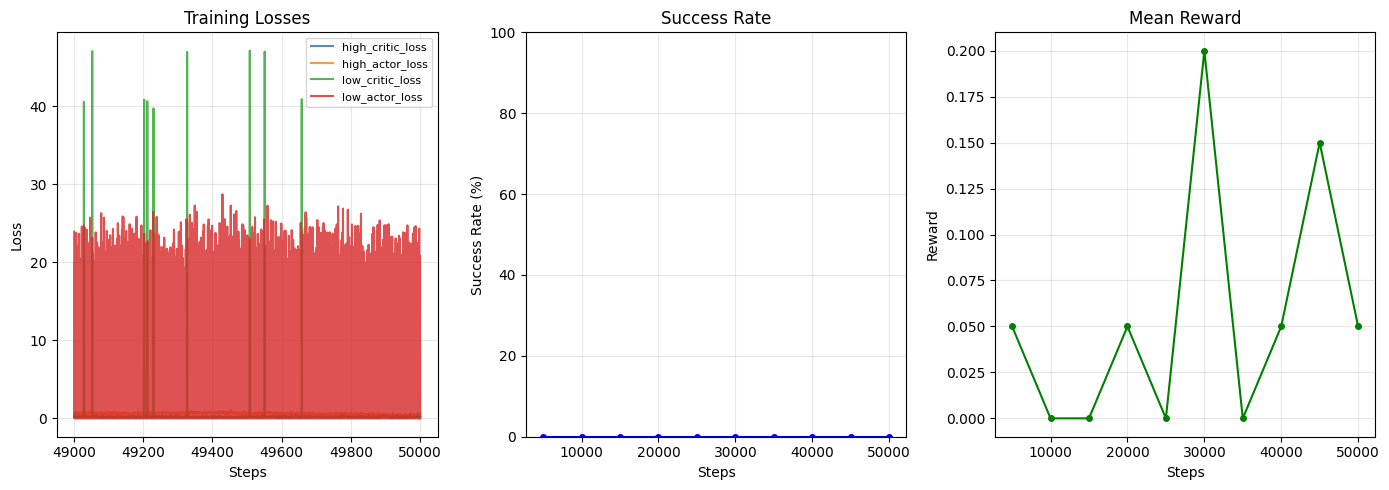


✓ HAC (with_her) Training completed!
Best success rate: 0.0%
Total episodes: 10
✓ Model saved to ./logs/tier3_live_large_hac_with_her_seed42/hac_agent.pt
  ✓ Seed 42 complete (1468.5s)
✓ Checkpoint saved: ./logs/checkpoint_large.pkl

✓ ALL EXPERIMENTS COMPLETE!
Total time: 284.1 minutes


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
# ============================================================================
# RUN ALL EXPERIMENTS (Both Mazes, All Methods)
# ============================================================================

import time
import pickle

print("# RUNNING ALL EXPERIMENTS")
print("# - Maze sizes: Small (UMaze), Large")
print("# - Methods: DQN (Dense), DQN +/- HER, SAC +/- HER, TQC +/- HER, HAC +/- HER")

# Storage for all results
all_results = {
    'tier1': [], 'tier2': [], 'sac': [], 'tqc': [], 'tier3': [],
}
experiment_times = {}
failed_experiments = []

# Iterate over maze sizes
for maze_size in ['small', 'large']:
    print(f"\n{'=' * 80}")
    print(f"MAZE: {MAZE_CONFIGS[maze_size]['name']} ({MAZE_CONFIGS[maze_size]['env_id']})")
    print(f"{'=' * 80}")

    config = ExperimentConfig().update_for_maze(maze_size)

    # Define all experiments
    experiments = [
        ('tier1', 'DQN Dense', lambda s: train_dqn_live(config, seed=s), {}),
        ('tier2', 'DQN no HER', lambda s: train_dqn_her_live(config, seed=s, use_her=False), {}),
        ('tier2', 'DQN with HER', lambda s: train_dqn_her_live(config, seed=s, use_her=True), {}),
        ('sac', 'SAC no HER', lambda s: train_sac_live(config, seed=s, use_her=False), {}),
        ('sac', 'SAC with HER', lambda s: train_sac_live(config, seed=s, use_her=True), {}),
        ('tqc', 'TQC no HER', lambda s: train_tqc_live(config, seed=s, use_her=False), {}),
        ('tqc', 'TQC with HER', lambda s: train_tqc_live(config, seed=s, use_her=True), {}),
        ('tier3', 'HAC no HER', lambda s: train_hac_live(config, seed=s, use_her=False), {}),
        ('tier3', 'HAC with HER', lambda s: train_hac_live(config, seed=s, use_her=True), {}),
    ]

    for tier, name, train_fn, _ in experiments:
        print(f"\n>>> {name} - {maze_size} maze")
        for seed in config.seeds:
            exp_key = f'{name}_{maze_size}_{seed}'
            try:
                start_time = time.time()
                model, eval_df = train_fn(seed)
                experiment_times[exp_key] = time.time() - start_time
                all_results[tier].append(eval_df)
                print(f"  ✓ Seed {seed} complete ({experiment_times[exp_key]:.1f}s)")
            except Exception as e:
                print(f"  ❌ Seed {seed} FAILED: {e}")
                import traceback
                traceback.print_exc()  # Print full traceback for debugging
                failed_experiments.append(exp_key)
                break

    # Checkpoint after each maze
    checkpoint_path = os.path.join(config.log_dir, f'checkpoint_{maze_size}.pkl')
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(all_results, f)
    print(f"✓ Checkpoint saved: {checkpoint_path}")

# Combine and save results
tier1_df = pd.concat(all_results['tier1'], ignore_index=True) if all_results['tier1'] else pd.DataFrame()
tier2_df = pd.concat(all_results['tier2'], ignore_index=True) if all_results['tier2'] else pd.DataFrame()
sac_df = pd.concat(all_results['sac'], ignore_index=True) if all_results['sac'] else pd.DataFrame()
tqc_df = pd.concat(all_results['tqc'], ignore_index=True) if all_results['tqc'] else pd.DataFrame()
tier3_df = pd.concat(all_results['tier3'], ignore_index=True) if all_results['tier3'] else pd.DataFrame()

# Save all results
all_df = pd.concat([tier1_df, tier2_df, sac_df, tqc_df, tier3_df], ignore_index=True)
all_df.to_csv(os.path.join(config.log_dir, 'all_results.csv'), index=False)

print("\n" + "=" * 80)
print("✓ ALL EXPERIMENTS COMPLETE!")
print(f"Total time: {sum(experiment_times.values()) / 60:.1f} minutes")
if failed_experiments:
    print(f"⚠️ Failed experiments: {failed_experiments}")
print("=" * 80)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

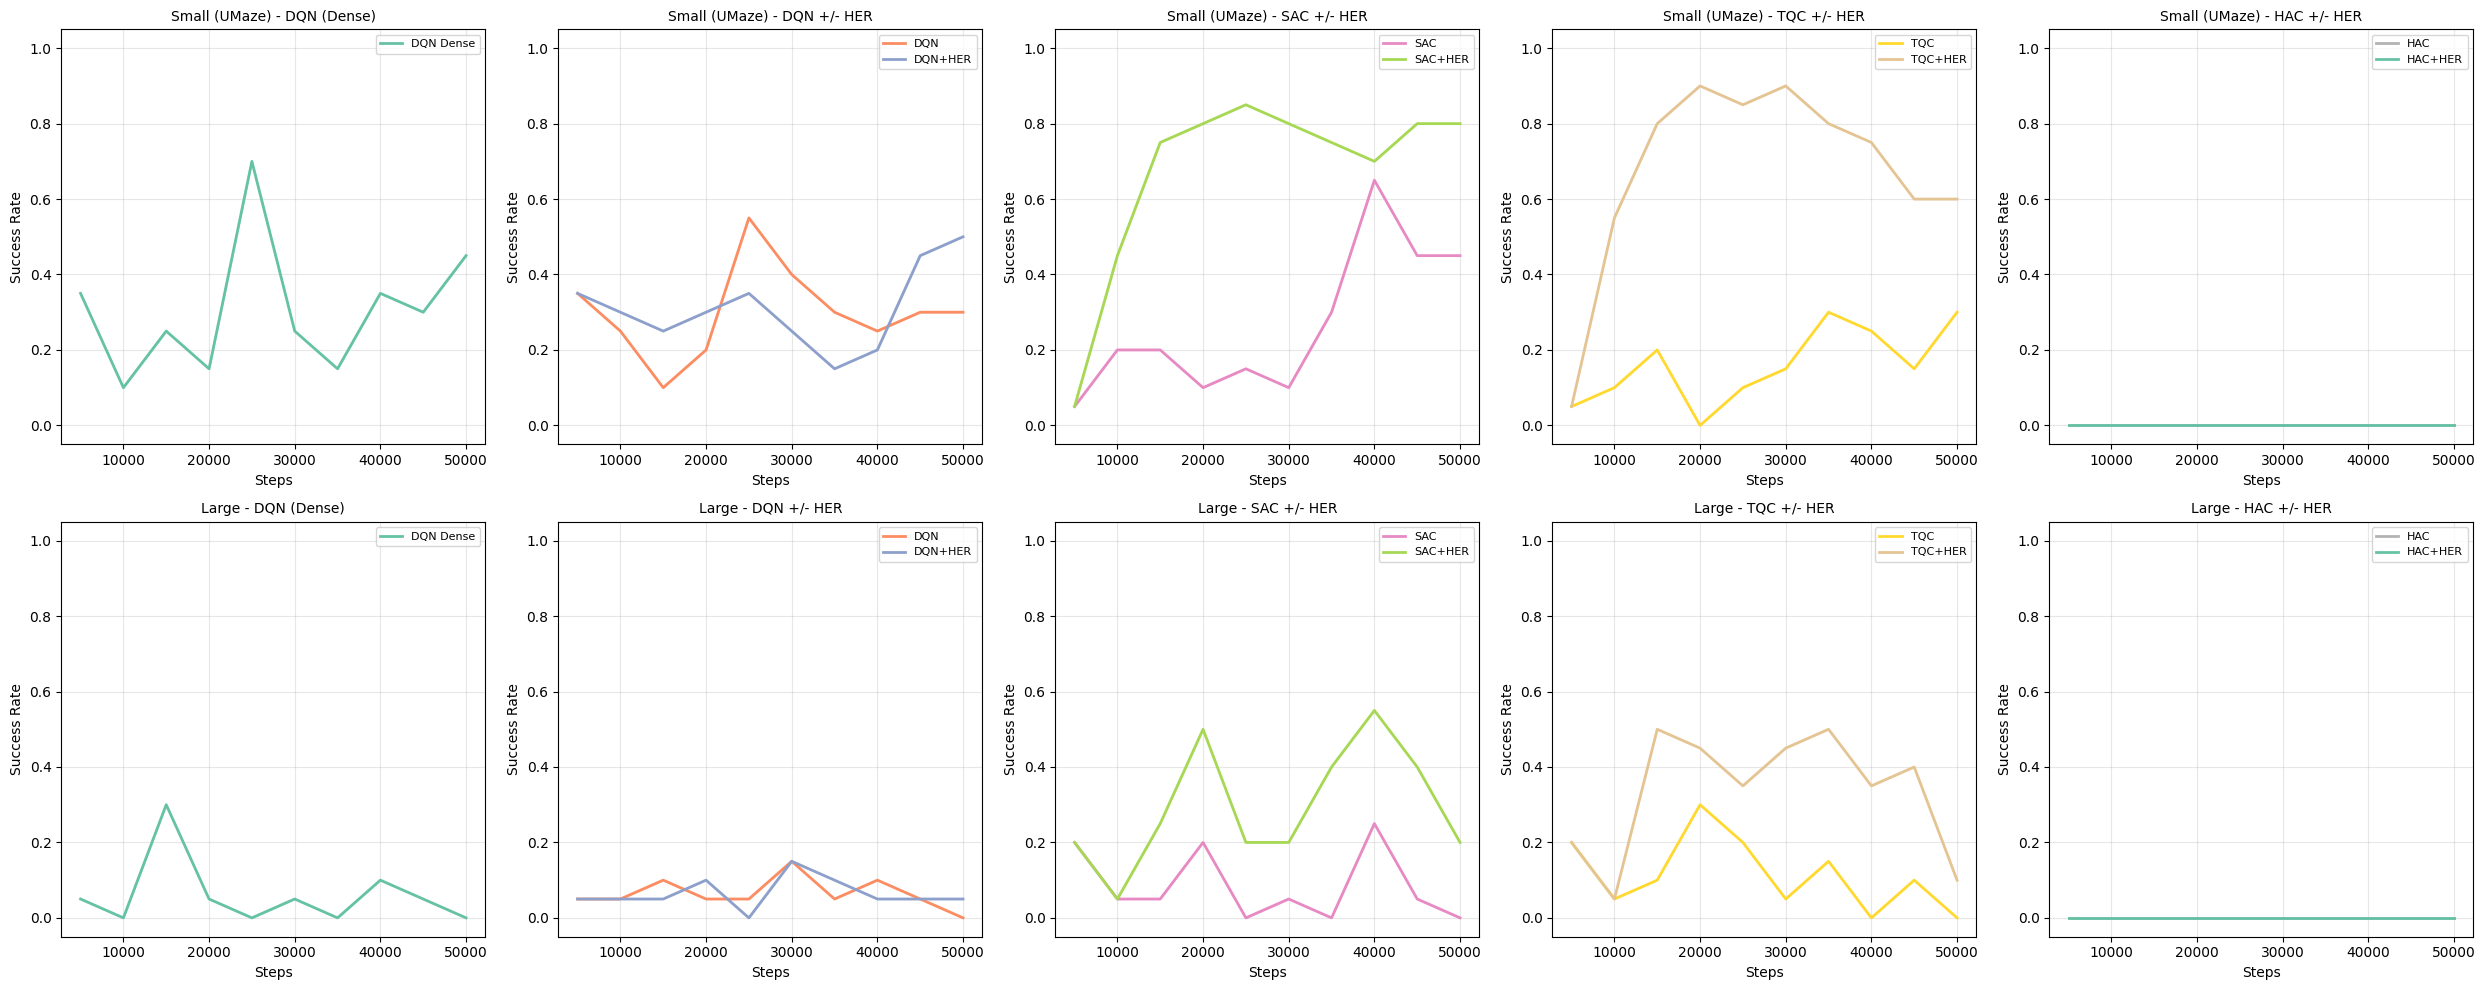

In [25]:
# ============================================================================
# VISUALIZATION: Learning Curves by Maze Size
# ============================================================================

def plot_learning_curves_by_maze(
    tier1_df, tier2_df, sac_df, tqc_df, tier3_df,
    save_dir: str = "./logs"
):
    """Plot learning curves grouped by maze size."""

    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    colors = plt.cm.Set2.colors

    for row, maze_size in enumerate(['small', 'large']):
        maze_name = MAZE_CONFIGS[maze_size]['name']

        # Tier 1: DQN Dense
        ax = axes[row, 0]
        ax.set_title(f'{maze_name} - DQN (Dense)', fontsize=10)
        if len(tier1_df) > 0:
            subset = tier1_df[tier1_df['maze_size'] == maze_size]
            if len(subset) > 0:
                agg = subset.groupby('timestep')['success_rate'].agg(['mean', 'std']).reset_index()
                ax.plot(agg['timestep'], agg['mean'], color=colors[0], linewidth=2, label='DQN Dense')
                ax.fill_between(agg['timestep'],
                               agg['mean'] - agg['std'].fillna(0),
                               agg['mean'] + agg['std'].fillna(0),
                               color=colors[0], alpha=0.2)
        ax.set_xlabel('Steps')
        ax.set_ylabel('Success Rate')
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

        # Tier 2: DQN +/- HER
        ax = axes[row, 1]
        ax.set_title(f'{maze_name} - DQN +/- HER', fontsize=10)
        if len(tier2_df) > 0:
            for j, use_her in enumerate([False, True]):
                subset = tier2_df[(tier2_df['maze_size'] == maze_size) & (tier2_df['use_her'] == use_her)]
                if len(subset) > 0:
                    agg = subset.groupby('timestep')['success_rate'].agg(['mean', 'std']).reset_index()
                    label = 'DQN+HER' if use_her else 'DQN'
                    ax.plot(agg['timestep'], agg['mean'], color=colors[j+1], linewidth=2, label=label)
                    ax.fill_between(agg['timestep'],
                                   agg['mean'] - agg['std'].fillna(0),
                                   agg['mean'] + agg['std'].fillna(0),
                                   color=colors[j+1], alpha=0.2)
        ax.set_xlabel('Steps')
        ax.set_ylabel('Success Rate')
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

        # SAC +/- HER
        ax = axes[row, 2]
        ax.set_title(f'{maze_name} - SAC +/- HER', fontsize=10)
        if len(sac_df) > 0:
            for j, use_her in enumerate([False, True]):
                subset = sac_df[(sac_df['maze_size'] == maze_size) & (sac_df['use_her'] == use_her)]
                if len(subset) > 0:
                    agg = subset.groupby('timestep')['success_rate'].agg(['mean', 'std']).reset_index()
                    label = 'SAC+HER' if use_her else 'SAC'
                    ax.plot(agg['timestep'], agg['mean'], color=colors[j+3], linewidth=2, label=label)
                    ax.fill_between(agg['timestep'],
                                   agg['mean'] - agg['std'].fillna(0),
                                   agg['mean'] + agg['std'].fillna(0),
                                   color=colors[j+3], alpha=0.2)
        ax.set_xlabel('Steps')
        ax.set_ylabel('Success Rate')
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

        # TQC +/- HER
        ax = axes[row, 3]
        ax.set_title(f'{maze_name} - TQC +/- HER', fontsize=10)
        if len(tqc_df) > 0:
            for j, use_her in enumerate([False, True]):
                subset = tqc_df[(tqc_df['maze_size'] == maze_size) & (tqc_df['use_her'] == use_her)]
                if len(subset) > 0:
                    agg = subset.groupby('timestep')['success_rate'].agg(['mean', 'std']).reset_index()
                    label = 'TQC+HER' if use_her else 'TQC'
                    ax.plot(agg['timestep'], agg['mean'], color=colors[j+5], linewidth=2, label=label)
                    ax.fill_between(agg['timestep'],
                                   agg['mean'] - agg['std'].fillna(0),
                                   agg['mean'] + agg['std'].fillna(0),
                                   color=colors[j+5], alpha=0.2)
        ax.set_xlabel('Steps')
        ax.set_ylabel('Success Rate')
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

        # HAC +/- HER
        ax = axes[row, 4]
        ax.set_title(f'{maze_name} - HAC +/- HER', fontsize=10)
        if len(tier3_df) > 0:
            for j, use_her in enumerate([False, True]):
                subset = tier3_df[(tier3_df['maze_size'] == maze_size) & (tier3_df['use_her'] == use_her)]
                if len(subset) > 0:
                    agg = subset.groupby('timestep')['success_rate'].agg(['mean', 'std']).reset_index()
                    label = 'HAC+HER' if use_her else 'HAC'
                    ax.plot(agg['timestep'], agg['mean'], color=colors[(j+7) % len(colors)], linewidth=2, label=label)
                    ax.fill_between(agg['timestep'],
                                   agg['mean'] - agg['std'].fillna(0),
                                   agg['mean'] + agg['std'].fillna(0),
                                   color=colors[(j+7) % len(colors)], alpha=0.2)
        ax.set_xlabel('Steps')
        ax.set_ylabel('Success Rate')
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    plt.tight_layout()

    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, 'learning_curves_all.png'), dpi=150, bbox_inches='tight')
    plt.show()

def plot_all_methods_combined(all_dfs, maze_size, ax):
    """Plot all methods on one axis for direct comparison."""
    method_configs = [
        (tier1_df, 'DQN Dense', False, 0),
        (tier2_df, 'DQN+HER', True, 1),
        (sac_df, 'SAC+HER', True, 2),
        (tqc_df, 'TQC+HER', True, 3),
        (tier3_df, 'HAC+HER', True, 4),
    ]
    # Plot only +HER variants for cleaner comparison
    for df, label, filter_her, color_idx in method_configs:
        if len(df) == 0:
            continue
        if filter_her:
            subset = df[(df['maze_size'] == maze_size) & (df['use_her'] == True)]
        else:
            subset = df[df['maze_size'] == maze_size]
        if len(subset) == 0:
            continue
        agg = subset.groupby('timestep')['success_rate'].agg(['mean', 'std']).reset_index()
        ax.plot(agg['timestep'], agg['mean'], linewidth=2, label=label)
    ax.legend()
    ax.set_title(f'{maze_size.title()} Maze - All Methods (+HER)')

# Plot results
plot_learning_curves_by_maze(tier1_df, tier2_df, sac_df, tqc_df, tier3_df, config.log_dir)

In [26]:
# ============================================================================
# EXPERIMENT SUMMARY
# ============================================================================

print("=" * 80)
print("EXPERIMENT SUMMARY")
print("=" * 80)

def print_final_metrics(df: pd.DataFrame, name: str, maze_size: str = None):
    """Print final metrics for a method."""
    if df is None or len(df) == 0:
        print(f"\n{name}: No data")
        return

    if maze_size:
        df = df[df['maze_size'] == maze_size]

    if len(df) == 0:
        print(f"\n{name}: No data for {maze_size} maze")
        return

    final_timestep = df['timestep'].max()
    final_data = df[df['timestep'] == final_timestep]

    success_mean = final_data['success_rate'].mean()
    success_std = final_data['success_rate'].std()
    steps_mean = final_data['mean_steps'].mean()
    efficiency_mean = final_data['mean_path_efficiency'].mean()

    print(f"\n{name}:")
    print(f"  Success Rate: {success_mean:.1%} ± {success_std:.1%}" if not np.isnan(success_std) else f"  Success Rate: {success_mean:.1%}")
    print(f"  Mean Steps: {steps_mean:.1f}")
    print(f"  Path Efficiency: {efficiency_mean:.2f}")

for maze_size in ['small', 'large']:
    print(f"\n{'=' * 40}")
    print(f"  {MAZE_CONFIGS[maze_size]['name']} MAZE")
    print(f"{'=' * 40}")

    print_final_metrics(tier1_df, "DQN (Dense Reward)", maze_size)

    if len(tier2_df) > 0:
        no_her = tier2_df[tier2_df['use_her'] == False]
        with_her = tier2_df[tier2_df['use_her'] == True]
        print_final_metrics(no_her, "DQN without HER (Sparse)", maze_size)
        print_final_metrics(with_her, "DQN with HER (Sparse)", maze_size)

    if len(sac_df) > 0:
        no_her = sac_df[sac_df['use_her'] == False]
        with_her = sac_df[sac_df['use_her'] == True]
        print_final_metrics(no_her, "SAC without HER (Continuous)", maze_size)
        print_final_metrics(with_her, "SAC with HER (Continuous)", maze_size)

    if len(tqc_df) > 0:
        no_her = tqc_df[tqc_df['use_her'] == False]
        with_her = tqc_df[tqc_df['use_her'] == True]
        print_final_metrics(no_her, "TQC without HER (Continuous)", maze_size)
        print_final_metrics(with_her, "TQC with HER (Continuous)", maze_size)

    if len(tier3_df) > 0:
        no_her = tier3_df[tier3_df['use_her'] == False]
        with_her = tier3_df[tier3_df['use_her'] == True]
        print_final_metrics(no_her, "HAC without HER (Continuous)", maze_size)
        print_final_metrics(with_her, "HAC with HER (Continuous)", maze_size)

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print("""
1. DQN (Discrete Actions):
   - Dense reward: Baseline with reward shaping
   - Sparse + HER: Learns via hindsight relabeling

2. SAC (Continuous Actions):
   - Actor-critic with entropy regularization
   - WITHOUT HER: Standard SAC on goal-conditioned task
   - WITH HER: SAC + hindsight relabeling

3. TQC (Continuous Actions):
   - Extends SAC with distributional critics
   - Truncated quantile estimation reduces overestimation
   - Generally more stable than SAC

4. HAC (Hierarchical, Continuous Actions):
   - Two-level hierarchy: high-level subgoals + low-level actions
   - WITHOUT HER: Hierarchical decomposition only
   - WITH HER: Full HAC with HER for both levels

EXPERIMENTAL NOTES:
- DQN uses discrete actions via wrapper
- SAC, TQC, HAC use native continuous actions
- Small maze provides easier baseline for debugging
- Large maze tests long-horizon planning capability
""")

# Save all results
os.makedirs(config.log_dir, exist_ok=True)

if len(tier1_df) > 0:
    tier1_df.to_csv(os.path.join(config.log_dir, 'tier1_results.csv'), index=False)
if len(tier2_df) > 0:
    tier2_df.to_csv(os.path.join(config.log_dir, 'tier2_results.csv'), index=False)
if len(sac_df) > 0:
    sac_df.to_csv(os.path.join(config.log_dir, 'sac_results.csv'), index=False)
if len(tqc_df) > 0:
    tqc_df.to_csv(os.path.join(config.log_dir, 'tqc_results.csv'), index=False)
if len(tier3_df) > 0:
    tier3_df.to_csv(os.path.join(config.log_dir, 'tier3_results.csv'), index=False)

print(f"\nAll results saved to: {config.log_dir}")

EXPERIMENT SUMMARY

  Small (UMaze) MAZE

DQN (Dense Reward):
  Success Rate: 45.0%
  Mean Steps: 337.2
  Path Efficiency: 1.13

DQN without HER (Sparse):
  Success Rate: 30.0%
  Mean Steps: 366.4
  Path Efficiency: 1.25

DQN with HER (Sparse):
  Success Rate: 50.0%
  Mean Steps: 281.0
  Path Efficiency: 1.06

SAC without HER (Continuous):
  Success Rate: 45.0%
  Mean Steps: 368.9
  Path Efficiency: 1.47

SAC with HER (Continuous):
  Success Rate: 80.0%
  Mean Steps: 180.8
  Path Efficiency: 1.50

TQC without HER (Continuous):
  Success Rate: 30.0%
  Mean Steps: 419.2
  Path Efficiency: 0.54

TQC with HER (Continuous):
  Success Rate: 60.0%
  Mean Steps: 233.2
  Path Efficiency: 1.89

HAC without HER (Continuous):
  Success Rate: 0.0%
  Mean Steps: 476.8
  Path Efficiency: 1.75

HAC with HER (Continuous):
  Success Rate: 0.0%
  Mean Steps: 338.2
  Path Efficiency: 0.77

  Large MAZE

DQN (Dense Reward):
  Success Rate: 0.0%
  Mean Steps: 5000.0
  Path Efficiency: 2.71

DQN without HER 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



All results saved to: ./logs


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


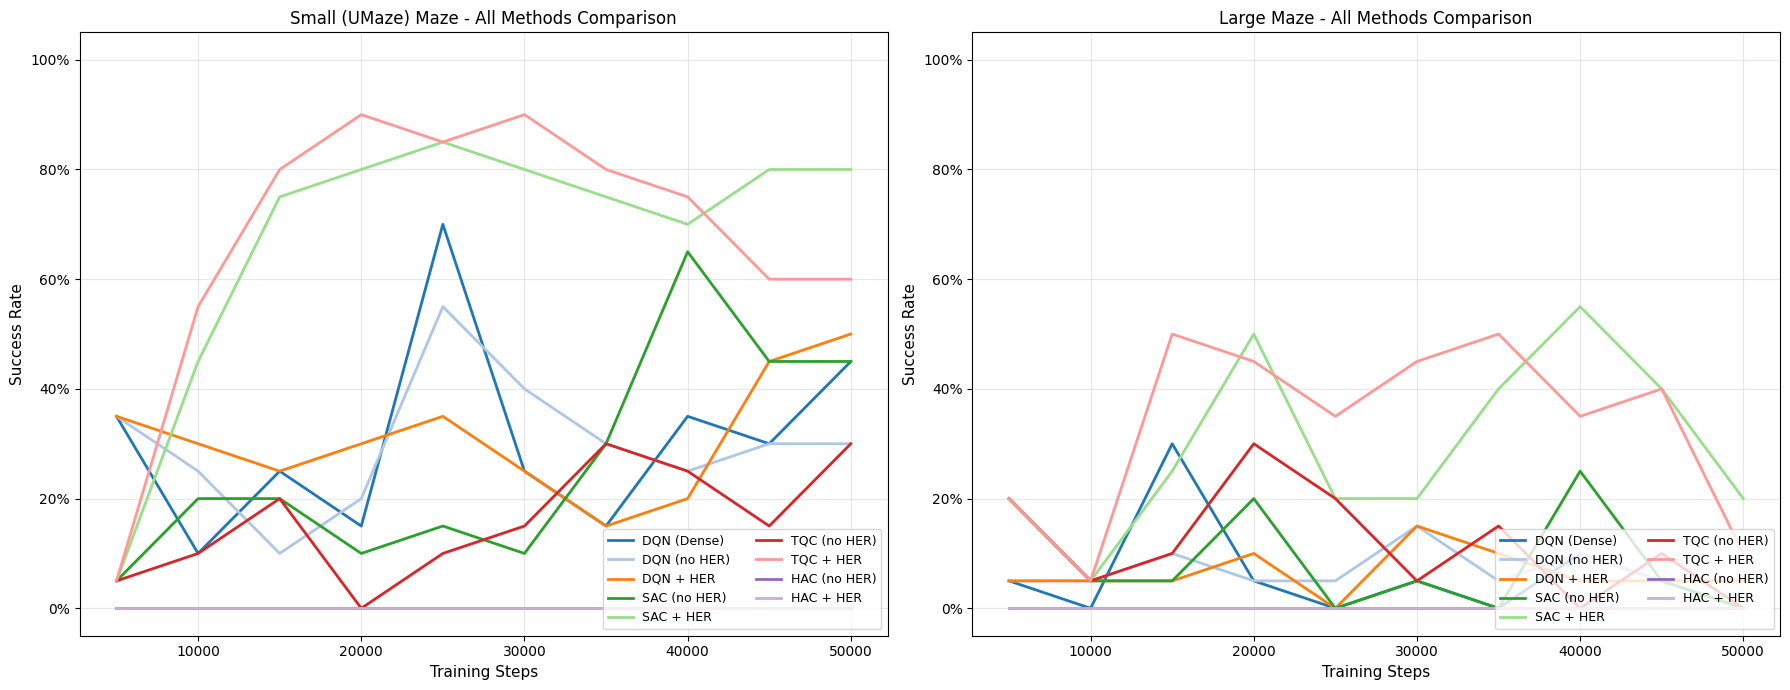

In [27]:
# ============================================================================
# COMPARISON PLOT: All Methods on Both Mazes
# ============================================================================

def plot_all_methods_comparison(tier1_df, tier2_df, sac_df, tqc_df, tier3_df, save_dir: str = "./logs"):
    """Create a comprehensive comparison plot of all methods."""

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Color scheme for all methods
    colors = {
        'DQN (Dense)': '#1f77b4',
        'DQN (no HER)': '#aec7e8',
        'DQN + HER': '#ff7f0e',
        'SAC (no HER)': '#2ca02c',
        'SAC + HER': '#98df8a',
        'TQC (no HER)': '#d62728',
        'TQC + HER': '#ff9896',
        'HAC (no HER)': '#9467bd',
        'HAC + HER': '#c5b0d5',
    }

    for idx, maze_size in enumerate(['small', 'large']):
        ax = axes[idx]
        maze_name = MAZE_CONFIGS[maze_size]['name']
        ax.set_title(f'{maze_name} Maze - All Methods Comparison', fontsize=12)

        # Define all methods to plot
        methods_data = [
            (tier1_df, None, 'DQN (Dense)'),
            (tier2_df, False, 'DQN (no HER)'),
            (tier2_df, True, 'DQN + HER'),
            (sac_df, False, 'SAC (no HER)'),
            (sac_df, True, 'SAC + HER'),
            (tqc_df, False, 'TQC (no HER)'),
            (tqc_df, True, 'TQC + HER'),
            (tier3_df, False, 'HAC (no HER)'),
            (tier3_df, True, 'HAC + HER'),
        ]

        for df, use_her, label in methods_data:
            if df is None or len(df) == 0:
                continue

            subset = df[df['maze_size'] == maze_size]
            if use_her is not None:
                subset = subset[subset['use_her'] == use_her]

            if len(subset) == 0:
                continue

            agg = subset.groupby('timestep')['success_rate'].agg(['mean', 'std']).reset_index()
            color = colors.get(label, '#000000')
            ax.plot(agg['timestep'], agg['mean'], color=color, linewidth=2, label=label)
            ax.fill_between(agg['timestep'],
                           agg['mean'] - agg['std'].fillna(0),
                           agg['mean'] + agg['std'].fillna(0),
                           color=color, alpha=0.15)

        ax.set_xlabel('Training Steps', fontsize=11)
        ax.set_ylabel('Success Rate', fontsize=11)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=9, ncol=2)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

    plt.tight_layout()

    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, 'all_methods_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()


# Plot comparison
plot_all_methods_comparison(tier1_df, tier2_df, sac_df, tqc_df, tier3_df, config.log_dir)